In [18]:
pip install intermine

In [1]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [2]:
!git init

Initialized empty Git repository in C:/Users/10096/machineLearning1/Project/.git/


In [3]:
!git remote add origin git@github.com:vellysmallwhite/MachineLearing-Project.git

In [4]:
!git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	FinalPaper.pdf
	Paper1.pdf
	Paper1.synctex.gz
	Paper1.tex
	Project.ipynb
	dataset/
	depmap_analysis/
	depmap_target_birc6/
	pj1.png
	pj10.png
	pj2.png
	pj3.png
	pj4.png
	pj5.png
	pj6.png
	pj7.png
	pj8.png
	pj9.png
	presentation.mp4
	presentation.pptx
	"\346\227\240\346\240\207\351\242\230.txt"

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
! git add Project.ipynb

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os, sys, re, pickle, math
from intermine.webservice import Service
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
def get_data(key):
    """Load input data.
    Arguments: key for the data source (eg: expression, sample_info...)
    1) If the data is cached on the filesystem, load and return the dataframe
    2) Otherwise, load the data from the source URL, cache, return the dataframe
    """
    
    data_cache = 'C:\\Users\\10096\\machineLearning1\\Project\\dataset\\'+key+'.csv'
    data_pic='C:\\Users\\10096\\machineLearning1\\Project\\dataset\\'+key+'.p'
    df = pd.read_csv(data_cache)
    df.to_pickle(data_pic)
    #if os.path.exists(data_cache):
        
  
        
     
    return df
def ncbi_gene_ids(genes):
    """Converts gene name "symbol (ncbi_id)"
    to integer NCBI ID.  Also catch missing associations
    for NCBI gene ID/symbol
    """
    ncbi_cols = []
    for g in genes:
        match = re.search('(\S+)\s+\((\d+)\)',g)
        if match:
            #s = match.group(1)
            g = match.group(2)
            #if not ncbi2symbol.get(int(g)):
                #ncbi2symbol[int(g)] = s
                #symbol2ncbi[s] = int(g)
            ncbi_cols.append(int(g))
        else:
            print("No match",g)
            ncbi_cols.append(g)
        
        

    return ncbi_cols

def get_pathway_info():
    # Map NCBI IDs to reactome pathways
    # File downloaded from https://reactome.org/download/current/NCBI2Reactome.txt
    archive = 'data/pathway_info.p'
    
    if os.path.exists(archive):
        pathway_info = pickle.load(open(archive,'rb'))
        return pathway_info
    
    pathway_info = {}
    if not os.path.exists('data/NCBI2Reactome.txt'):
        wget.download(A.url['reactome'],out='data/NCBI2Reactome.txt')
    with open('data/NCBI2Reactome.txt') as n2r:
        for line in n2r.readlines():
            ncbi, pathway_id, url, pathway_name, type, species = line.strip().split('\t')
            # only human pathways
            if species != 'Homo sapiens':
                continue
            # only curated pathways
            if type == 'IEA':
                continue
            pathway_info[ncbi] = [pathway_id, url, pathway_name]

    pickle.dump(pathway_info,open(archive,'wb'))
    return pathway_info

def get_gene_descriptions():
    """Load gene names and descriptions from humanmine (http://www.humanmine.org),
    an integrated database of human genome information.  Use cached data if available"""
    
    archive = 'C:\\Users\\10096\\machineLearning1\\Project\\dataset\\gene_info.p'
    if os.path.exists(archive):
        df = pd.read_pickle(archive)
        return df
    
    service = Service("https://www.humanmine.org/humanmine/service")
    query = service.new_query("Gene")
    cols = ["primaryIdentifier", "symbol", "briefDescription", "description","proteins.uniprotAccession"]
    query.add_view(*cols)
    query.add_constraint("organism.taxonId", "=", "9606", code = "A")    
    df_rows = []

    for row in query.rows():
        df_rows.append(
            [row["primaryIdentifier"], 
             row["symbol"], 
             row["briefDescription"], 
             row["description"],
             row["proteins.uniprotAccession"]
            ])

    df = pd.DataFrame(data=df_rows,columns=cols)
    df.to_pickle(archive)
    return df

# Get Gene Description

In [3]:
gd = get_gene_descriptions()
#printmd('sample gene info:')
display(gd.head())
ncbi2name    = {}
ncbi2symbol  = {}
symbol2ncbi  = {}
ncbi2desc    = {}
ncbi2uniprot = {}
uniprot2ncbi = {}

for i, r in gd.iterrows():
    ncbi, symbol, name, description, uniprot = list(r)
    ncbi = int(ncbi)
    ncbi2name[ncbi] = name
    ncbi2symbol[ncbi] = symbol
    ncbi2desc[ncbi] = description
    
    # ncbi <-> uniprot can be 1:many
    if ncbi2uniprot.get(ncbi) is None:
        ncbi2uniprot[ncbi] = set()
    ncbi2uniprot[ncbi].add(uniprot)
    uniprot2ncbi[uniprot] = ncbi
    
print("Done mapping gene info")

,primaryIdentifier,symbol,briefDescription,description,proteins.uniprotAccession
0,2632,GBE1,"1,4-alpha-glucan branching enzyme 1",None,Q04446
1,10554,AGPAT1,1-acylglycerol-3-phosphate O-acyltransferase 1,None,Q99943
2,10555,AGPAT2,1-acylglycerol-3-phosphate O-acyltransferase 2,None,A0A024R8F9
3,10555,AGPAT2,1-acylglycerol-3-phosphate O-acyltransferase 2,None,O15120
4,10555,AGPAT2,1-acylglycerol-3-phosphate O-acyltransferase 2,None,O15120


Done mapping gene info


In [4]:
ncbi2symbol

{2632: 'GBE1',
 10554: 'AGPAT1',
 10555: 'AGPAT2',
 56894: 'AGPAT3',
 56895: 'AGPAT4',
 55326: 'AGPAT5',
 84680: 'ACCS',
 390110: 'ACCSL',
 3248: 'HPGD',
 1267: 'CNP',
 4938: 'OAS1',
 4939: 'OAS2',
 4940: 'OAS3',
 8638: 'OASL',
 10591: 'DNPH1',
 1666: 'DECR1',
 26063: 'DECR2',
 84890: 'ADO',
 26061: 'HACL1',
 55239: 'OGFOD1',
 79676: 'OGFOD2',
 79701: 'OGFOD3',
 92370: 'PXYLP1',
 1718: 'DHCR24',
 10380: 'BPNT1',
 54928: 'BPNT2',
 9061: 'PAPSS1',
 9060: 'PAPSS2',
 3155: 'HMGCL',
 3156: 'HMGCR',
 3157: 'HMGCS1',
 3158: 'HMGCS2',
 9200: 'HACD1',
 201562: 'HACD2',
 51495: 'HACD3',
 401494: 'HACD4',
 23498: 'HAAO',
 622: 'BDH1',
 56898: 'BDH2',
 11112: 'HIBADH',
 26275: 'HIBCH',
 54511: 'HMGCLL1',
 2531: 'KDSR',
 5019: 'OXCT1',
 64064: 'OXCT2',
 54995: 'OXSM',
 5170: 'PDPK1',
 18: 'ABAT',
 112817: 'HOGA1',
 3242: 'HPD',
 84842: 'HPDL',
 30833: 'NT5C',
 56953: 'NT5M',
 54464: 'XRN1',
 22803: 'XRN2',
 211: 'ALAS1',
 212: 'ALAS2',
 221294: 'NT5DC1',
 64943: 'NT5DC2',
 51559: 'NT5DC3',
 4907: '

In [6]:
sample_info = get_data('sample_info')
lineages = set(sample_info.lineage.dropna())
lineages

{'adrenal_cortex',
 'bile_duct',
 'blood',
 'bone',
 'breast',
 'central_nervous_system',
 'cervix',
 'colorectal',
 'embryo',
 'epidermoid_carcinoma',
 'esophagus',
 'eye',
 'fibroblast',
 'gastric',
 'kidney',
 'liver',
 'lung',
 'lymphocyte',
 'ovary',
 'pancreas',
 'peripheral_nervous_system',
 'plasma_cell',
 'prostate',
 'skin',
 'soft_tissue',
 'thyroid',
 'unknown',
 'upper_aerodigestive',
 'urinary_tract',
 'uterus'}

In [7]:
lineage2cell    = {}
sublineage2cell = {}
cell2lineage    = {}
cell2sublineage = {}
has_sub = set()
is_sub = set()

for l in lineages:
    ldf = sample_info[sample_info.lineage == l]
    subtypes = set(ldf.lineage_subtype.dropna())
    
    # cell lines for sublineage
    if len(subtypes) > 1:
        has_sub.add(l)
        for sub in subtypes:
            if l in sub:
                lname = sub
            else:
                lname = l + '_' + sub

            is_sub.add(lname)
            sub_df = ldf[ldf.lineage_subtype == sub]

            # map sublineage to cell lines
            sublineage2cell[lname] = list(sub_df.index)
    
            # map cell lines to sub-lineage
            for cell in sublineage2cell[lname]:
                cell2sublineage[cell] = lname
    else:
        sublineage2cell[l] = list(ldf.index)
        for cell in sublineage2cell[l]:
            cell2sublineage[cell] = l
                
    # all cell lines for lineage
    lineage2cell[l] = list(ldf.index)
    
    # parent lineage of each cell line
    for cell in lineage2cell[l]:
        cell2lineage[cell] = l
print("Number of cell lines: "+str(len(cell2lineage)))
print("Number of lineages: "+str(len(lineage2cell)))
print("Number of lineages with sub-lineages: "+str(len(has_sub)))
print("Number of sub-lineages "+str(len(is_sub)))


Number of cell lines: 1840
Number of lineages: 30
Number of lineages with sub-lineages: 25
Number of sub-lineages 106


In [9]:
cell2lineage[4]

'kidney'

# Load Expression Dataset

In [8]:
exp = get_data('CCLE_expression').T
exp=exp.dropna()
exp=exp.dropna(axis=1)
exp.index = ncbi_gene_ids(list(exp.index))
#exp.index
display(exp)

No match Unnamed: 0


,0,1,2,3,4,5,6,7,8,9,...,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405
Unnamed: 0,ACH-001113,ACH-001289,ACH-001339,ACH-001538,ACH-000242,ACH-000708,ACH-000327,ACH-000233,ACH-000461,ACH-000705,...,ACH-001578,ACH-000036,ACH-000973,ACH-001128,ACH-000750,ACH-000285,ACH-002669,ACH-001858,ACH-001997,ACH-000052
7105,4.331992,4.566815,3.15056,5.08534,6.729145,4.272023,3.337711,0.056584,4.01614,4.411426,...,6.344828,4.018812,4.328406,5.994806,3.533563,0.056584,3.109361,4.390943,5.057017,4.247928
64102,0.0,0.584963,0.0,0.0,0.0,0.189034,0.0,0.0,0.0,0.0,...,3.400538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8813,7.364397,7.106537,7.379032,7.154109,6.537607,7.022923,5.927185,6.093602,6.533875,6.412443,...,7.211207,6.700578,7.058749,6.238787,6.488322,6.604071,7.031219,7.013127,7.814935,6.174127
57147,2.792855,2.543496,2.333424,2.545968,2.456806,2.555816,1.944858,3.970854,2.226509,2.364572,...,2.533563,2.137504,1.891419,2.304511,1.823749,3.264536,1.541019,1.887525,2.538538,2.316146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728929,0.0,0.0,0.0,0.0,0.0,0.0,0.124328,0.0,0.0,0.0,...,0.0,0.0,0.042644,0.0,0.0,0.0,0.0,0.0,0.0,0.042644
2831,0.275007,0.014355,0.084064,0.028569,0.464668,0.0,0.176323,0.0,0.014355,0.042644,...,0.028569,0.014355,0.014355,0.0,0.124328,0.0,0.014355,1.464668,0.0,0.0
100506888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056584,0.028569,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162699,0.0,0.0,0.0,0.0,0.0,0.0,0.084064,0.0,0.0,0.0,...,0.0,0.0,0.042644,0.0,0.0,0.475085,0.0,0.0,0.0,0.176323


# Load Mutation data

In [11]:
mutations = get_data('CCLE_mutations')
mutations

C:\Users\10096\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3364: DtypeWarning: Columns (3,19,22,27,28,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,Variant_annotation,CGA_WES_AC,HC_AC,RD_AC,RNAseq_AC,SangerWES_AC,WGS_AC
0,VPS13D,55187,37,1,12359347,12359347,+,Nonsense_Mutation,SNP,C,...,False,0.0,NaN,damaging,34:213,NaN,NaN,NaN,34:221,NaN
1,AADACL4,343066,37,1,12726308,12726322,+,In_Frame_Del,DEL,CTGGCGTGACGCCAT,...,False,3.0,NaN,other non-conserving,57:141,NaN,NaN,NaN,9:0,28:32
2,IFNLR1,163702,37,1,24484172,24484172,+,Silent,SNP,G,...,False,0.0,NaN,silent,118:0,NaN,NaN,10:0,118:0,18:0
3,TMEM57,55219,37,1,25785018,25785019,+,Frame_Shift_Ins,INS,-,...,False,0.0,NaN,damaging,NaN,NaN,NaN,6:28,NaN,NaN
4,ZSCAN20,7579,37,1,33954141,33954141,+,Missense_Mutation,SNP,T,...,False,0.0,NaN,other non-conserving,28:62,NaN,NaN,NaN,27:61,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235461,GSN,2934,37,9,124064366,124064366,+,Silent,SNP,C,...,False,0.0,0.000016,silent,33:0,NaN,NaN,NaN,NaN,NaN
1235462,NOTCH1,4851,37,9,139390940,139390940,+,Silent,SNP,C,...,False,1.0,0.000083,silent,39:0,NaN,NaN,NaN,NaN,NaN
1235463,MAGEC1,9947,37,X,140995050,140995050,+,Missense_Mutation,SNP,A,...,False,0.0,NaN,other non-conserving,5:32,NaN,NaN,NaN,NaN,NaN
1235464,MAGEA3,4102,37,X,151935812,151935812,+,Missense_Mutation,SNP,A,...,False,0.0,NaN,other non-conserving,13:16,NaN,NaN,NaN,NaN,NaN


In [12]:
hotspots = []
hotspots.append(mutations[mutations.isTCGAhotspot])

hotspots.append(mutations[mutations.isCOSMIChotspot])
hotspots = pd.concat(hotspots).drop_duplicates()

hotspot_genes = set(hotspots.Entrez_Gene_Id)

lineage_hotspots = {}
sublineage_hotspots = {}

for g in hotspot_genes:
    lineage_hotspots[g] = {}
    sublineage_hotspots[g] = {}
    
    gdf = hotspots[hotspots.Entrez_Gene_Id == g]
    
    for i, r in gdf.iterrows():
        cell = r.DepMap_ID
        if cell2lineage.get(cell) is not None:
            lineage = cell2lineage[cell]
            if lineage_hotspots[g].get(lineage) is None:
                lineage_hotspots[g][lineage] = 0
            lineage_hotspots[g][lineage] += 1
            
        if cell2sublineage.get(cell) is not None:
            sublineage = cell2sublineage[cell]
            if sublineage_hotspots[g].get(sublineage) is None:
                sublineage_hotspots[g][sublineage] = 0
            sublineage_hotspots[g][sublineage]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

# Load Copy Number Data

In [10]:
cn = get_data('CCLE_gene_cn')
cn.columns = ncbi_gene_ids(list(cn.columns))

# cn.columns = ncbi_gene_ids(list(cn.columns))
# print(cn.shape)
# keep_genes = []
# for g in cn.columns:
#     if g in hotspot_genes:
#         keep_genes.append(g)
# cn = cn[keep_genes]
# print(cn.shape)
cn = cn.T

display(cn.head())

display(cn.iloc[:,:10])

No match Unnamed: 0


,0,1,2,3,4,5,6,7,8,9,...,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765
Unnamed: 0,ACH-000267,ACH-001408,ACH-000617,ACH-002123,ACH-000519,ACH-000750,ACH-000544,ACH-001214,ACH-002223,ACH-000713,...,ACH-001376,ACH-000419,ACH-002249,ACH-000979,ACH-002124,ACH-001065,ACH-000341,ACH-000567,ACH-001087,ACH-000526
84771,1.149159,1.039446,0.762353,1.137564,1.005822,0.710801,0.981308,1.046217,0.629528,0.823041,...,0.972602,1.357596,0.903583,0.787837,0.591247,1.205677,1.057336,0.998783,1.038911,0.737911
653635,1.149159,1.039446,0.762353,1.137564,1.005822,0.710801,0.981308,1.046217,0.629528,0.823041,...,0.972602,1.357596,0.903583,0.787837,0.591247,1.205677,1.057336,0.998783,1.038911,0.737911
102466751,1.149159,1.039446,0.762353,1.137564,1.005822,0.710801,0.981308,1.046217,0.629528,0.823041,...,0.972602,1.357596,0.903583,0.787837,0.591247,1.205677,1.057336,0.998783,1.038911,0.737911
100302278,1.149159,1.039446,0.762353,1.137564,1.005822,0.710801,0.981308,1.046217,0.629528,0.823041,...,0.972602,1.357596,0.903583,0.787837,0.591247,1.205677,1.057336,0.998783,1.038911,0.737911


,0,1,2,3,4,5,6,7,8,9
Unnamed: 0,ACH-000267,ACH-001408,ACH-000617,ACH-002123,ACH-000519,ACH-000750,ACH-000544,ACH-001214,ACH-002223,ACH-000713
84771,1.149159,1.039446,0.762353,1.137564,1.005822,0.710801,0.981308,1.046217,0.629528,0.823041
653635,1.149159,1.039446,0.762353,1.137564,1.005822,0.710801,0.981308,1.046217,0.629528,0.823041
102466751,1.149159,1.039446,0.762353,1.137564,1.005822,0.710801,0.981308,1.046217,0.629528,0.823041
100302278,1.149159,1.039446,0.762353,1.137564,1.005822,0.710801,0.981308,1.046217,0.629528,0.823041
...,...,...,...,...,...,...,...,...,...,...
442868,0.542163,0.510792,0.0,0.471769,0.0,0.0,0.284829,0.463796,0.609359,0.0
474150,0.542163,0.510792,0.0,0.471769,0.0,0.0,0.284829,0.463796,0.609359,0.0
114758,0.542163,0.510792,0.0,0.471769,0.0,0.0,0.284829,0.463796,0.609359,0.0
9085,0.542163,0.510792,0.0,0.471769,0.0,0.0,0.284829,0.463796,0.609359,0.0


In [ ]:
keep_common_genes = []
keep_common_cells = []
keep_lineage = set()
keep_pairs = set()


for sublin in lineage2cell:
    cells = lineage2cell[sublin]
    print(sublin,len(cells))
    
    best = {}
    for cell in cells:
        try:
            cdf = cn[cell]
            #cdf = cdf[cdf >= 2]
            #if len(cdf.index) > 0:
            best[cell] = set(cdf.index)
        except Exception as e:
            #print('Error',e)
            continue
            
    if len(best) == 0:
        continue
        
    best_genes = list(best.values())
    set1 = best_genes.pop()
    all_genes = set1.union(*best_genes)

    total = len(best_genes) + 1
    common_genes = []
    for g in all_genes:
        gcount = 0
        for gset in [set1,*best_genes]:
            if g in gset:
                gcount += 1
        if gcount / total >= 0.8:
            common_genes.append(g)
        
        
    keep_common_genes.extend(common_genes)
    common_symbols = [ncbi2symbol.get(g) for g in common_genes]
    if len(common_genes) > 0:
        keep_lineage.add(sublin)
        keep_common_cells.extend(cells)
        print(sublin+'; '+str(len(cells))+' cell lines; '+str(len(common_genes))+' high copy number genes')
        # Remember the gene:cell pairs to assemble the final table
        for cg in common_genes:
            for cell in cells:
                keep_pairs.add((cg,cell))


keep_common_genes = set(keep_common_genes)
keep_common_cells = set(keep_common_cells)

In [ ]:
keep_pairs

# Load gene Dependency

In [11]:
achilles = get_data('CRISPRGeneEffect').T
achilles=achilles.dropna()
achilles=achilles.dropna(axis=1)
genes = list(achilles.index)
achilles.index = ncbi_gene_ids(genes)
print(achilles.shape[0],"genes")
print(achilles.shape[1],"cell lines")

achilles.head()

No match Unnamed: 0
17454 genes
1078 cell lines


,0,1,2,3,4,5,6,7,8,9,...,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077
Unnamed: 0,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,...,ACH-002283,ACH-002284,ACH-002285,ACH-002294,ACH-002295,ACH-002296,ACH-002297,ACH-002298,ACH-002304,ACH-002305
1,0.014633,-0.261566,-0.028717,0.000225,0.095791,-0.10898,-0.077777,-0.05374,-0.189235,-0.009789,...,-0.109261,-0.092109,-0.156263,0.026595,-0.036315,-0.073879,0.084735,-0.172365,-0.033065,0.076307
29974,-0.032777,0.174833,-0.117017,-0.283124,-0.099622,0.05862,-0.078709,-0.157498,-0.035974,-0.028755,...,0.069098,-0.024094,0.278745,-0.336219,-0.225388,0.046252,-0.249753,-0.112164,0.171028,-0.241877
2,-0.151299,0.106526,0.030971,0.051248,0.022204,0.172384,0.026442,0.038028,-0.081227,-0.003561,...,0.034826,0.052046,0.006431,0.002214,0.114886,-0.077086,0.045093,0.055771,-0.044622,0.165187
144568,-0.071388,0.135635,0.083795,0.120321,0.199771,0.223336,0.100746,0.057477,0.040641,0.022338,...,0.203743,0.123172,0.104118,0.220993,0.164997,0.028623,0.070714,-0.017571,0.185127,-0.088436


# Data preprocessing

In [12]:
exp1 = exp.copy()
ac1 = achilles.copy()
si=sample_info.T.copy()
exp_genes = set(exp1.index)
ac_genes = set(ac1.index)
shared_genes = ac_genes.intersection(exp_genes)


In [13]:
exp2 = exp.copy()
ac2 = achilles.copy()
cop2=cn.copy()
si2=sample_info.T.copy()
exp2_genes = set(exp2.index)
ac2_genes = set(ac2.index)
cop2_genes=set(cop2.index)
shared2_genes = ac2_genes.intersection(exp2_genes)
shared2_genes=shared2_genes.intersection(cop2_genes)
common2_cols = list(set(exp2.iloc[0]) & set(achilles.iloc[0])& set(cn.iloc[0]))


In [16]:


exp2.columns = exp2.iloc[0]
exp2=exp2.iloc[1: , :]
exp2=exp2[common2_cols]

ac2.columns = ac2.iloc[0]
ac2=ac2.iloc[1: , :]
ac2=ac2[common2_cols]

cop2.columns = cop2.iloc[0]
cop2=cop2.iloc[1: , :]
cop2=cop2[common2_cols]


si2.columns = si2.iloc[0]
si2=si2.iloc[1: , :]
si2=si2[common2_cols].T
y1=si2.lineage


In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Fit the LabelEncoder object on the list of labels
le.fit(y1)

# Transform the list of labels to a numpy array of numbers
y1_encoded = le.transform(y1)

# Print the encoded labels
#print(y_encoded)
y1_decoded = le.inverse_transform(y1_encoded)

# Print the decoded labels
print(y1_decoded)

['esophagus' 'skin' 'bone' 'breast' 'liver' 'urinary_tract' 'pancreas'
 'peripheral_nervous_system' 'colorectal' 'kidney' 'colorectal'
 'soft_tissue' 'lung' 'central_nervous_system' 'upper_aerodigestive'
 'peripheral_nervous_system' 'central_nervous_system' 'eye' 'uterus'
 'lung' 'central_nervous_system' 'lymphocyte' 'gastric' 'lymphocyte'
 'lung' 'upper_aerodigestive' 'central_nervous_system' 'bone' 'colorectal'
 'upper_aerodigestive' 'lung' 'plasma_cell' 'central_nervous_system'
 'central_nervous_system' 'skin' 'peripheral_nervous_system' 'breast'
 'upper_aerodigestive' 'bile_duct' 'gastric' 'central_nervous_system'
 'uterus' 'upper_aerodigestive' 'ovary' 'cervix' 'esophagus' 'blood'
 'bone' 'upper_aerodigestive' 'bone' 'ovary' 'central_nervous_system'
 'kidney' 'esophagus' 'ovary' 'urinary_tract' 'blood' 'blood'
 'upper_aerodigestive' 'bile_duct' 'skin' 'blood' 'eye' 'lung' 'ovary'
 'kidney' 'lung' 'ovary' 'pancreas' 'urinary_tract' 'colorectal' 'blood'
 'colorectal' 'ovary' 'bile_d

In [26]:
expaccn_s = pd.concat([exp2_s, ac2_s,cop2_s])
expaccn_np = expaccn_s.to_numpy().T

In [28]:
cop2_np = cop2_s.to_numpy().T
ac2_np = ac2_s.to_numpy().T
exp2_np = exp2_s.to_numpy().T

In [577]:
common_cols = list(set(exp.iloc[0]) & set(achilles.iloc[0]))  # get common columns
#common_cols.remove('Unname_0')

ValueError: list.remove(x): x not in list

In [485]:
len(common_cols)

1003

In [546]:


exp1.columns = exp1.iloc[0]
exp1=exp1.iloc[1: , :]
exp1=exp1[common_cols]

ac1.columns = ac1.iloc[0]
ac1=ac1.iloc[1: , :]
ac1=ac1[common_cols]

si.columns = si.iloc[0]
si=si.iloc[1: , :]
si1=si[common_cols].T
y=si1.lineage


In [547]:
si1.lineage

DepMap_ID
ACH-000665                      lung
ACH-000336                     blood
ACH-000090                  prostate
ACH-000452                 esophagus
ACH-000025    central_nervous_system
                       ...          
ACH-000001                     ovary
ACH-000155                  pancreas
ACH-001396                    breast
ACH-000181       upper_aerodigestive
ACH-000459                    kidney
Name: lineage, Length: 1003, dtype: object

In [548]:
exp1

Unnamed: 0,ACH-000665,ACH-000336,ACH-000090,ACH-000452,ACH-000025,ACH-000381,ACH-000159,ACH-000605,ACH-000123,ACH-000093,...,ACH-000248,ACH-000809,ACH-000164,ACH-000252,ACH-001522,ACH-000001,ACH-000155,ACH-001396,ACH-000181,ACH-000459
7105,4.252476,0.111031,4.554589,4.595146,4.020591,5.224581,3.836934,4.379205,2.946731,4.380591,...,3.428946,4.563158,1.887525,4.921246,5.130107,5.183487,3.145677,2.998196,3.419539,2.857981
64102,0.028569,0.0,0.0,0.0,0.0,0.400538,0.0,0.0,0.275007,0.0,...,0.0,0.0,0.0,0.084064,0.0,0.0,0.0,0.0,0.0,0.0
8813,6.023699,5.196135,6.303598,7.911272,6.674263,6.344296,7.361681,6.473949,6.527321,6.464178,...,6.869871,7.08183,6.25153,6.778997,6.992768,7.497453,7.479214,5.397803,5.923862,6.220136
57147,2.400538,2.419539,1.485427,2.330558,1.95977,2.601697,2.0,2.207893,1.761285,2.169925,...,3.500802,1.811471,2.339137,2.916477,2.090853,2.107688,2.080658,2.485427,2.253989,2.837943
55732,3.615887,3.07382,3.560715,3.516015,4.265287,4.129283,3.513491,4.098453,3.160275,3.397803,...,4.31904,4.050502,3.553361,3.0,2.769772,4.217231,3.621759,3.349082,3.432959,4.167519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728929,0.028569,0.056584,0.0,0.0,0.0,0.0,0.028569,0.0,0.028569,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070389
2831,3.576522,0.0,0.014355,1.516015,0.0,0.0,1.405992,0.422233,0.028569,0.084064,...,0.0,0.895303,0.084064,0.070389,0.014355,0.028569,0.0,0.0,0.422233,0.111031
100506888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056584,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014355,0.070389
162699,0.028569,0.0,0.0,0.0,0.0,0.0,0.028569,0.0,0.028569,0.0,...,0.0,0.0,0.028569,0.0,0.028569,0.214125,0.0,0.0,0.014355,0.070389


In [549]:
ac1

Unnamed: 0,ACH-000665,ACH-000336,ACH-000090,ACH-000452,ACH-000025,ACH-000381,ACH-000159,ACH-000605,ACH-000123,ACH-000093,...,ACH-000248,ACH-000809,ACH-000164,ACH-000252,ACH-001522,ACH-000001,ACH-000155,ACH-001396,ACH-000181,ACH-000459
1,0.015368,-0.101066,-0.029772,-0.025577,-0.146707,-0.012354,-0.098583,-0.052689,-0.171145,-0.145047,...,0.002416,-0.020667,-0.084872,-0.030552,0.078521,-0.194499,0.080036,0.250727,-0.019336,0.26795
29974,-0.114766,0.230718,-0.542138,-0.152326,-0.202706,-0.019142,-0.194067,-0.167935,-0.138952,-0.015833,...,0.063888,0.037682,-0.032226,-0.071415,0.003611,0.179631,-0.278739,-0.187352,-0.080939,0.109894
2,0.111143,-0.066437,-0.087904,-0.00668,0.015312,0.126914,0.056482,-0.061728,-0.119689,-0.167657,...,-0.100308,0.125821,-0.008106,0.020598,0.009008,0.028873,-0.043332,-0.18917,0.005454,-0.075965
144568,0.101334,-0.053427,-0.228798,-0.022273,0.144107,0.032771,-0.043275,0.172637,0.003046,-0.117147,...,0.153427,-0.015892,0.073624,-0.007608,0.208019,-0.009102,-0.014372,0.098221,-0.036166,-0.025078
127550,-0.064433,-0.00126,-0.097476,-0.097336,0.017333,0.089683,0.042775,-0.142172,-0.072543,0.264161,...,0.018039,0.100027,-0.059057,-0.229842,-0.213218,-0.037817,-0.059556,0.104633,0.001501,-0.43082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440590,-0.049653,-0.072783,0.223653,-0.076944,-0.039667,0.002001,-0.214984,-0.076657,-0.090218,0.200665,...,0.038255,-0.019853,-0.075109,0.011085,0.022947,-0.129938,0.026773,0.069821,-0.055334,-0.299293
79699,-0.255227,-0.03032,-0.194165,-0.11315,-0.182173,-0.08987,-0.222925,-0.166538,-0.130607,-0.14416,...,-0.217992,-0.104178,-0.111848,-0.162631,-0.175761,0.009006,-0.095805,-0.445775,-0.134023,-0.248029
7791,0.087354,0.08465,-0.272645,-0.076489,-0.1216,-0.187867,0.01554,0.009123,0.086481,0.02186,...,-0.03532,-0.024989,0.062998,-0.179454,-0.055719,0.098376,-0.286638,0.00971,-0.04146,-0.006301
23140,-0.124793,-0.197379,-0.145055,-0.199976,-0.241791,-0.048348,-0.105381,-0.045206,-0.164289,-0.188801,...,0.005027,-0.050555,-0.20355,-0.015128,-0.333089,0.113812,-0.164191,-0.044248,0.066615,0.037596


In [536]:
si1.lineage

DepMap_ID
ACH-000665                      lung
ACH-000336                     blood
ACH-000090                  prostate
ACH-000452                 esophagus
ACH-000025    central_nervous_system
                       ...          
ACH-000001                     ovary
ACH-000155                  pancreas
ACH-001396                    breast
ACH-000181       upper_aerodigestive
ACH-000459                    kidney
Name: lineage, Length: 1003, dtype: object

In [453]:
set(exp.columns)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [587]:
#my_exp = exp.copy()
keep_genes = set()
for g in shared_genes:
    #if g in keep_common_genes:
        keep_genes.add(g)

keep_genes.remove('Unnamed: 0')
        
exp_s = exp1
exp_s.columns.name=None
exp_s = exp_s.T[keep_genes].T
exp_s = exp_s[~exp_s.index.duplicated(keep='first')]
ac_s = ac1
ac_s.columns.name=None
ac_s = ac_s.T[keep_genes].T


exp_data = exp_s.to_numpy().flatten()
ac_data = ac_s.to_numpy().flatten()

# remove NaN and Inf
keep_exp = []
keep_ac = []
print(str(len(exp_data))+":"+str(len(ac_data)))
for i, num1 in enumerate(exp_data):
    num2 = ac_data[i]
    #print(num1)
    #print(type(num1), type(num2))
    if isinstance(num1, str) or isinstance(num2, str) or (not np.isfinite(float(num1)) and np.isfinite(float(num2))):
        continue
    keep_exp.append(num1)
    keep_ac.append(num2)
exp_data = keep_exp
ac_data = keep_ac 

17492320:17492320


In [588]:
exp_s

,ACH-000665,ACH-000336,ACH-000090,ACH-000452,ACH-000025,ACH-000381,ACH-000159,ACH-000605,ACH-000123,ACH-000093,...,ACH-000248,ACH-000809,ACH-000164,ACH-000252,ACH-001522,ACH-000001,ACH-000155,ACH-001396,ACH-000181,ACH-000459
1,5.73064,5.297925,1.263034,4.612352,4.24184,0.111031,0.201634,3.258519,4.888987,0.014355,...,2.516015,0.028569,4.726831,0.137504,1.594549,3.116032,3.0268,5.171127,4.238023,4.587965
2,0.15056,0.176323,0.124328,1.87578,0.056584,0.056584,0.669027,1.195348,7.00742,0.389567,...,1.438293,0.0,0.084064,0.378512,10.567956,0.226509,0.014355,0.111031,0.111031,0.014355
131076,5.20085,4.634593,5.776367,5.204767,6.564378,5.827565,4.810443,5.947199,5.175525,4.80787,...,5.32625,6.56864,5.918863,5.807097,6.451706,8.015025,6.098874,5.336283,4.181103,5.907852
9,2.198494,2.815575,2.485427,2.339137,1.773996,2.720278,2.127633,1.989139,0.454176,4.929791,...,2.570463,2.946731,0.485427,2.611172,3.023255,2.620586,3.235727,1.545968,1.594549,0.782409
10,0.731183,0.0,0.042644,0.0,0.028569,0.411426,0.286881,0.137504,0.0,0.275007,...,0.604071,0.028569,0.0,2.456806,0.0,0.201634,0.028569,0.344828,0.056584,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,2.214125,0.070389,2.776104,3.106013,0.189034,0.263034,3.106013,2.217231,1.819668,0.871844,...,2.82171,1.321928,2.032101,0.422233,2.422233,3.31034,1.505891,2.025029,3.336283,1.014355
327657,0.0,0.0,0.0,0.097611,0.0,0.028569,0.111031,0.15056,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.189034,0.0,0.594549,0.056584
201895,5.406673,1.691534,2.459432,4.308885,2.443607,3.838952,3.295723,3.529821,2.669027,4.999549,...,5.22033,2.035624,4.652486,3.823749,4.228049,3.193772,1.263034,4.990047,3.716991,4.380591
26048,2.568032,2.510962,1.550901,2.744161,1.778209,2.675816,2.632268,2.192194,2.689299,2.662205,...,3.24184,2.114367,2.843984,2.883621,1.903038,3.061776,2.9855,1.244887,2.83996,2.57289


In [476]:
exp_s = exp_s.replace(' ', np.nan)

# Impute missing values with the mean of the column
ac_data_num = exp_s.apply(lambda x: pd.to_numeric(x, errors='coerce'))
mean_value = ac_data_num.mean()
exp_s = ac_data_num.fillna(mean_value)

In [477]:
ac_s = ac_s.replace(' ', np.nan)

# Impute missing values with the mean of the column
ac_data_num = ac_s.apply(lambda x: pd.to_numeric(x, errors='coerce'))
mean_value = ac_data_num.mean()
ac_s = ac_data_num.fillna(mean_value)

In [361]:
y

['kidney',
 'blood',
 'lung',
 'fibroblast',
 'kidney',
 'soft_tissue',
 'lung',
 'lymphocyte',
 'fibroblast',
 'blood',
 'lymphocyte',
 'fibroblast',
 'blood',
 'colorectal',
 'pancreas',
 'gastric',
 'fibroblast',
 'blood',
 'fibroblast',
 'blood',
 'lymphocyte',
 'fibroblast',
 'lymphocyte',
 'fibroblast',
 'blood',
 'prostate',
 'soft_tissue',
 'uterus',
 'fibroblast',
 'lung',
 'fibroblast',
 'fibroblast',
 'fibroblast',
 'pancreas',
 'esophagus',
 'lymphocyte',
 'fibroblast',
 'fibroblast',
 'fibroblast',
 'gastric',
 'blood',
 'fibroblast',
 'fibroblast',
 'lymphocyte',
 'breast',
 'lung',
 'kidney',
 'kidney',
 'blood',
 'gastric',
 'central_nervous_system',
 'ovary',
 'fibroblast',
 'kidney',
 'lymphocyte',
 'lymphocyte',
 'fibroblast',
 'bone',
 'plasma_cell',
 'plasma_cell',
 'central_nervous_system',
 'blood',
 'colorectal',
 'blood',
 'ovary',
 'kidney',
 'lung',
 'fibroblast',
 'fibroblast',
 'fibroblast',
 'soft_tissue',
 'lung',
 'plasma_cell',
 'plasma_cell',
 'blood',

# 1)Correlation

In [42]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
corr_df = pd.DataFrame(index=exp2_s.index, columns=['corr_coeff'])
for gene in exp2_s.index:
    corr, _ = pearsonr(exp2_s.loc[gene], ac2_s.loc[gene])
    corr_df.loc[gene, 'corr_coeff'] = corr

# Identify genes with high expression and high correlation coefficients
top_genes = corr_df.sort_values(by='corr_coeff', ascending=False).head(100).index
high_exp_genes = exp2_s.loc[top_genes][exp2_s.mean(axis=1) > np.percentile(exp2_s.mean(axis=1), 90)].index

print("Top  genes with high correlation coefficients and high expression levels in descending order:")
top_hexp=[]
for i in list(high_exp_genes):
    if i in ncbi2symbol:
        top_hexp.append(ncbi2symbol[i])
    
#top_hexp = [ncbi2symbol(v) for v in list(high_exp_genes) if v in ncbi2symbol]
print(top_hexp)

C:\Users\10096\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Top  genes with high correlation coefficients and high expression levels in descending order:
['RPA2', 'UXT', 'GSS', 'EIF3G', 'ATP6AP2', 'PSMD6', 'EIF2S3', 'SRPRA', 'RPL30', 'TAF1D', 'MED10', 'RBM8A', 'RBX1', 'TXN', 'SOD2', 'RNASEK', 'WTAP', 'ATP6AP1']


C:\Users\10096\AppData\Local\Temp/ipykernel_31132/3798585935.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_exp_genes = exp2_s.loc[top_genes][exp2_s.mean(axis=1) > np.percentile(exp2_s.mean(axis=1), 90)].index


In [44]:
my_list=corr_df.sort_values(by='corr_coeff', ascending=False).head(100)

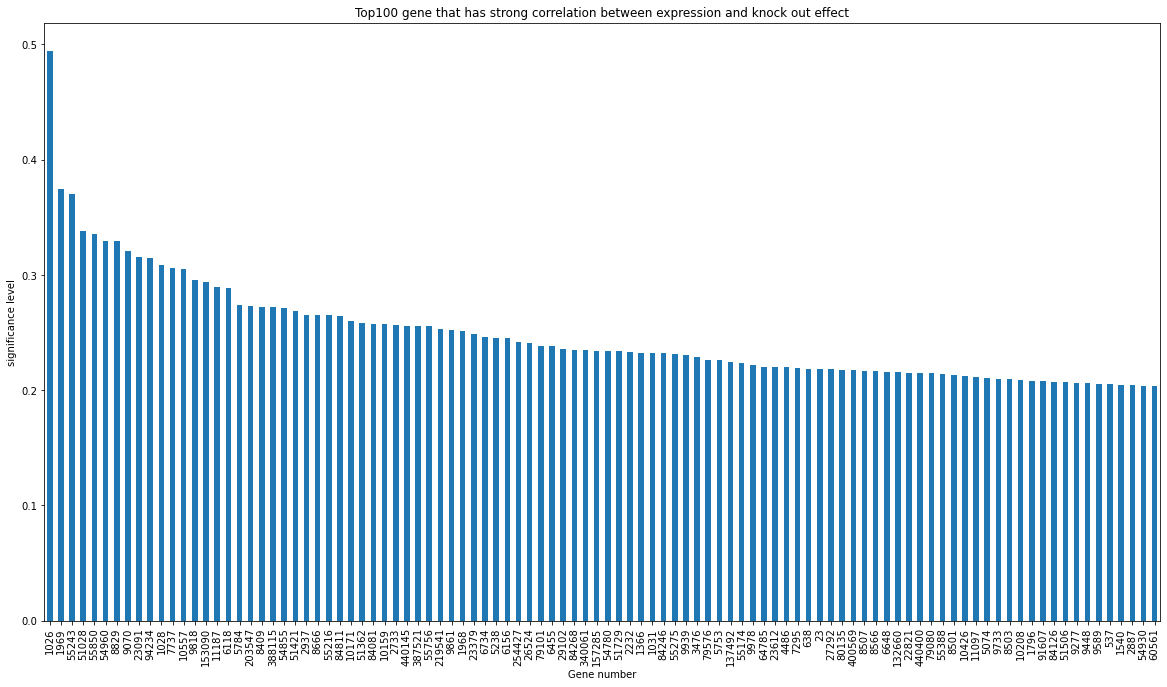

In [58]:
plt.figure(figsize=(20, 11))
my_list.iloc[:, 0].plot(kind='bar')

# Set the x-axis label
plt.xlabel('Gene number')

# Set the y-axis label
plt.ylabel('significance level')

# Set the title
plt.title('Top100 gene that has strong correlation between expression and knock out effect')

# Show the plot
plt.show()

In [165]:
exp2_s = exp2_s.astype(float)
ac2_s = ac2_s.astype(float)

In [167]:
ac2_s

,ACH-000654,ACH-001550,ACH-000054,ACH-000934,ACH-000108,ACH-000862,ACH-000905,ACH-001536,ACH-000504,ACH-000805,...,ACH-000838,ACH-000609,ACH-001970,ACH-000209,ACH-001388,ACH-000541,ACH-000391,ACH-002847,ACH-000639,ACH-000549
1,0.072404,-0.119952,-0.188757,0.106570,-0.119966,-0.058901,0.008300,-0.162080,-0.084814,-0.027450,...,-0.084958,-0.171587,-0.319893,-0.140414,-0.111173,0.012873,0.030585,0.040683,0.053321,-0.079485
2,0.046701,0.187239,-0.012258,-0.024351,0.085561,-0.055385,-0.023700,0.015888,0.005536,-0.038612,...,-0.002115,0.130811,-0.028771,-0.084079,0.008131,-0.134565,0.000451,0.014433,0.007802,-0.038222
131076,-0.333824,-0.317985,-0.713601,-0.246498,-0.294877,-0.137806,-0.636967,-0.244356,-0.436652,-0.452883,...,-0.345816,-0.509335,-0.093179,-0.865616,-0.320462,-0.903516,-0.373650,-0.454947,-0.401631,-0.365930
9,0.071005,0.012346,0.060026,0.124552,0.157938,-0.024065,0.057669,0.012588,0.037563,-0.045270,...,0.135085,0.016780,0.067794,0.088251,0.065703,-0.046219,0.141347,0.049417,0.022487,0.230045
10,-0.085152,0.125056,0.021910,-0.089847,-0.040499,0.062060,0.033087,-0.045644,0.010422,0.261830,...,0.012320,-0.055682,0.050173,0.125346,0.081699,0.294038,-0.078705,0.051836,0.013097,0.028723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,-0.090872,-0.147864,0.087718,-0.055847,0.001371,0.091489,0.017548,0.049166,-0.054139,-0.002436,...,0.158170,0.153982,-0.115363,-0.139578,0.051976,0.068244,0.016363,0.067949,0.042176,-0.046792
327657,0.083834,-0.015736,0.042073,-0.153960,0.106099,-0.118489,0.079331,0.019737,-0.036806,0.004936,...,0.077015,0.063750,0.018525,-0.021936,0.070230,0.133307,-0.011386,0.074047,0.062007,0.134953
201895,0.108313,0.178159,0.034507,0.021438,0.132500,0.107199,-0.005645,0.033900,0.035044,0.009509,...,0.050105,0.096585,0.146652,0.140622,0.056395,0.130900,0.054721,0.111661,0.127151,0.034059
26048,0.134324,-0.158821,-0.082838,-0.065323,-0.096208,-0.137044,-0.173622,-0.234787,0.008237,-0.121126,...,-0.083024,0.066493,0.074852,-0.183510,-0.019363,-0.053178,-0.055140,-0.122524,-0.100511,-0.047596


In [169]:
exp2_s

,ACH-000654,ACH-001550,ACH-000054,ACH-000934,ACH-000108,ACH-000862,ACH-000905,ACH-001536,ACH-000504,ACH-000805,...,ACH-000838,ACH-000609,ACH-001970,ACH-000209,ACH-001388,ACH-000541,ACH-000391,ACH-002847,ACH-000639,ACH-000549
1,0.321928,3.423578,3.330558,2.427606,0.464668,0.042644,0.226509,1.137504,0.485427,5.477030,...,4.436961,3.405992,2.456806,1.014355,1.627607,2.815575,4.399171,2.990955,0.286881,0.056584
2,0.378512,0.238787,0.263034,0.963474,0.124328,0.111031,0.150560,0.687061,10.286558,7.428444,...,0.042644,0.910733,6.914206,0.263034,0.000000,0.111031,0.111031,7.608440,0.214125,0.400538
131076,6.338781,5.896514,6.509696,5.862947,5.364572,5.680043,6.601697,6.191602,5.043519,5.373996,...,5.442943,5.935695,6.535431,4.719183,1.713696,6.148731,4.688740,5.158256,5.891905,4.786596
9,2.550901,2.395063,1.752749,2.330558,1.918386,3.000000,2.333424,2.063503,2.247928,2.516015,...,2.599318,2.572890,1.914565,1.182692,0.378512,3.522307,1.531069,3.695994,2.801159,2.664483
10,0.000000,0.298658,0.704872,0.378512,0.070389,0.137504,0.163499,0.163499,0.000000,0.000000,...,0.000000,0.028569,0.014355,0.310340,0.250962,0.000000,0.000000,0.000000,0.000000,0.111031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,0.042644,1.847997,2.726831,2.885574,0.565597,0.298658,3.420887,0.765535,3.580145,3.700440,...,0.056584,3.221877,1.464668,2.176323,0.163499,0.028569,2.480265,1.883621,0.163499,2.238787
327657,6.435629,0.000000,0.042644,0.124328,0.000000,0.000000,0.137504,0.056584,0.028569,0.000000,...,0.000000,0.137504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014355
201895,4.997744,5.055282,2.084064,6.729689,4.612942,5.428611,1.803227,5.336997,4.223423,1.843984,...,1.238787,4.044394,3.475085,3.134221,1.275007,2.173127,4.043519,3.734439,1.613532,3.939227
26048,2.395063,1.887525,2.456806,3.771886,2.462052,3.198494,2.257011,1.448901,2.666757,2.729009,...,1.384050,2.459432,1.516015,2.786596,0.226509,2.229588,2.833902,2.580145,2.987321,2.666757


In [149]:
corr_matrix = exp2_s.corrwith(ac2_s)
corr_matrix

Series([], dtype: float64)

In [118]:
list(high_exp_genes)

[6118,
 8409,
 2937,
 8666,
 10159,
 9861,
 1968,
 6734,
 6156,
 79101,
 84246,
 9939,
 9978,
 7295,
 6648,
 440400,
 51506,
 9589,
 537]

# PCA

10.001447439193726 seconds passed


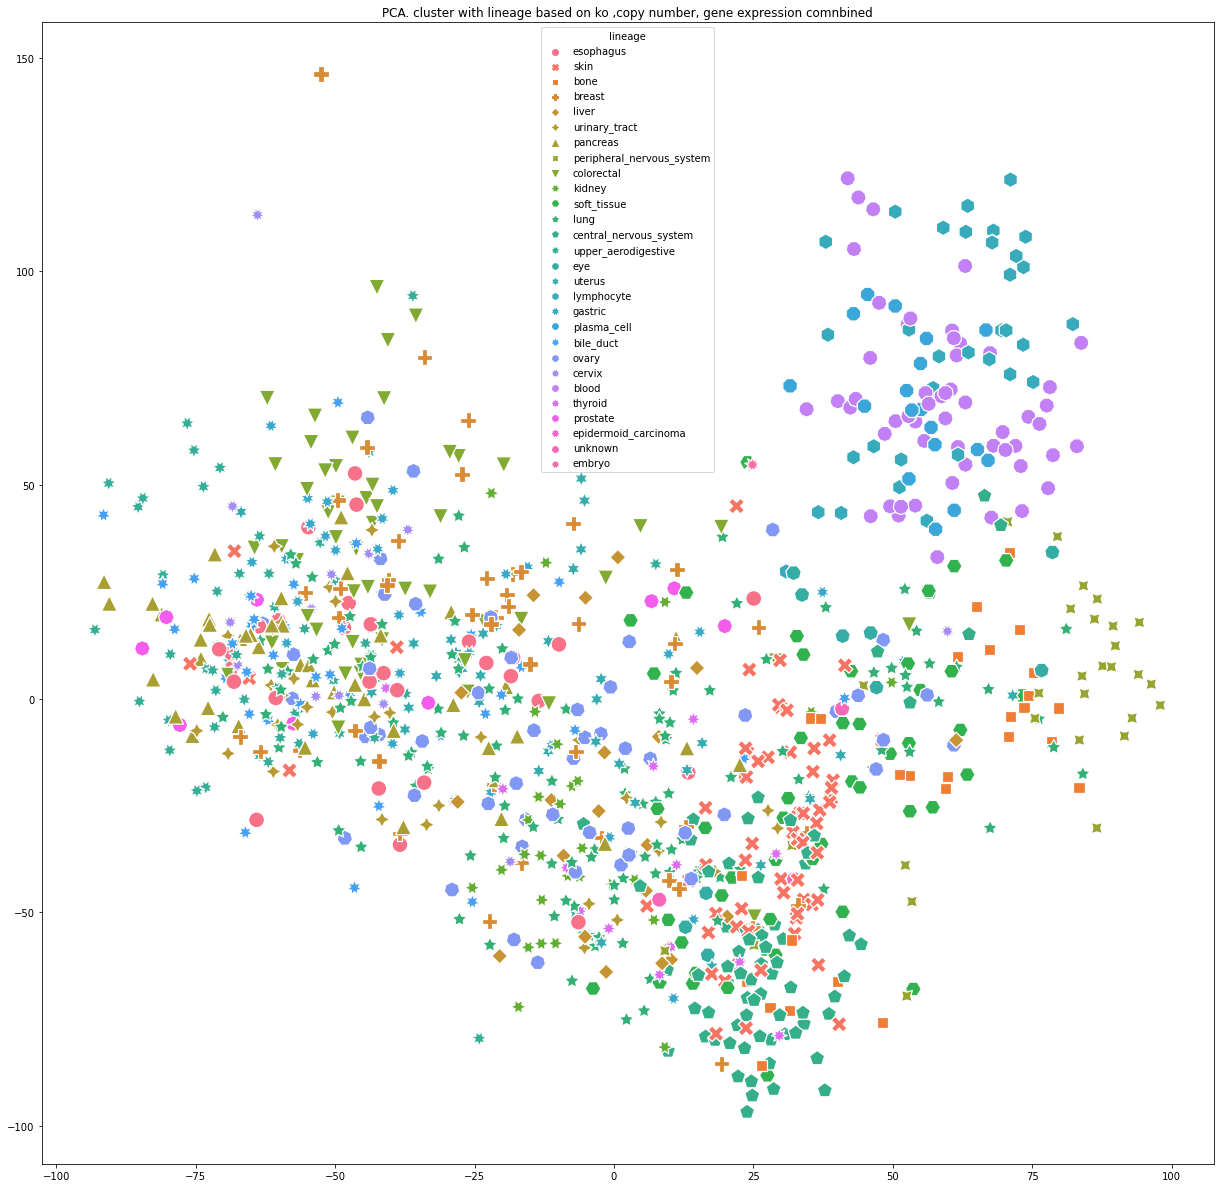

In [61]:
import matplotlib.pyplot as plt
import seaborn  as sns
from sklearn.decomposition import TruncatedSVD # for sparse 
from sklearn.decomposition import PCA
import time
#expac_s = pd.concat([exp_s, ac_s])
#scaler = StandardScaler()

#X = scaler.fit_transform(exp_s.values.T)
X = expaccn_s.values.T

t0 = time.time()
# svd = TruncatedSVD( n_components=2, n_iter=7, random_state=42)
reducer1 = PCA()# n_components=2)
r = reducer1.fit_transform(X)
print(time.time() - t0, 'seconds passed')

t0 = time.time()
plt.figure(figsize = (21,21))
sns.scatterplot(x=r[:,0],y=r[:,1] , hue= y1, style =y1 , s = 250 )
plt.title('PCA. cluster with lineage based on ko ,copy number, gene expression comnbined')
plt.show()


10.018194437026978 seconds passed


Text(0.5, 1.0, 'PCA. cluster with lineage based on ko data')

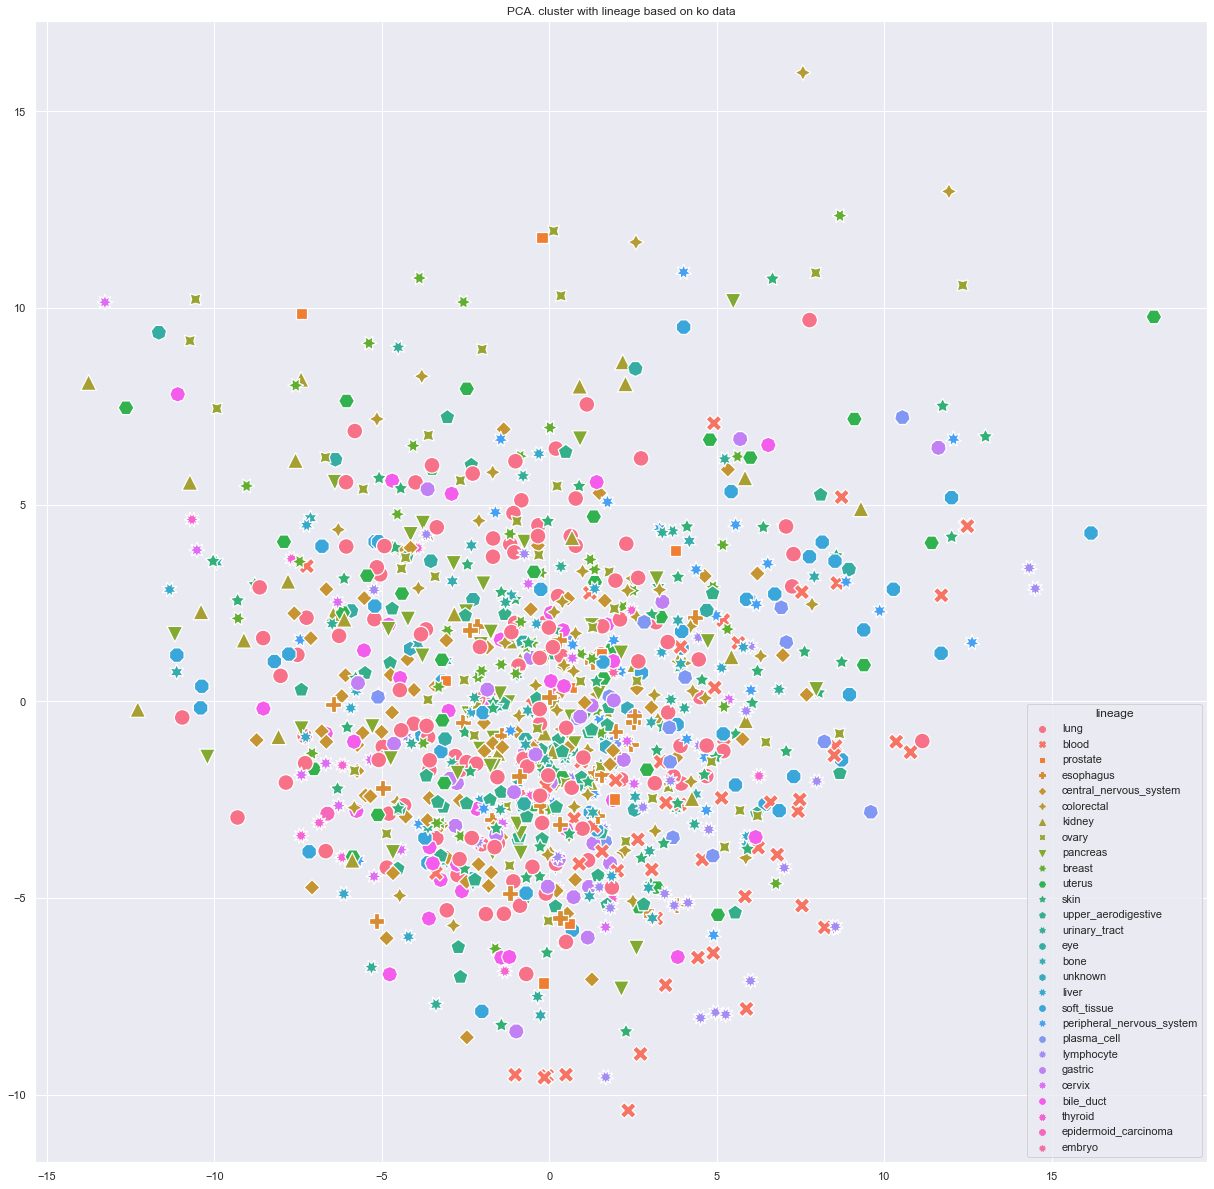

In [593]:
X = ac_s.values.T

t0 = time.time()
# svd = TruncatedSVD( n_components=2, n_iter=7, random_state=42)
reducer1 = PCA()# n_components=2)
r = reducer1.fit_transform(X)
print(time.time() - t0, 'seconds passed')

t0 = time.time()
plt.figure(figsize = (21,21))
sns.scatterplot(x=r[:,0],y=r[:,1] , hue= y, style =y , s = 250 )
plt.title('PCA. cluster with lineage based on ko data')

10.55204701423645 seconds passed


Text(0.5, 1.0, 'PCA. cluster with lineage based on expression data')

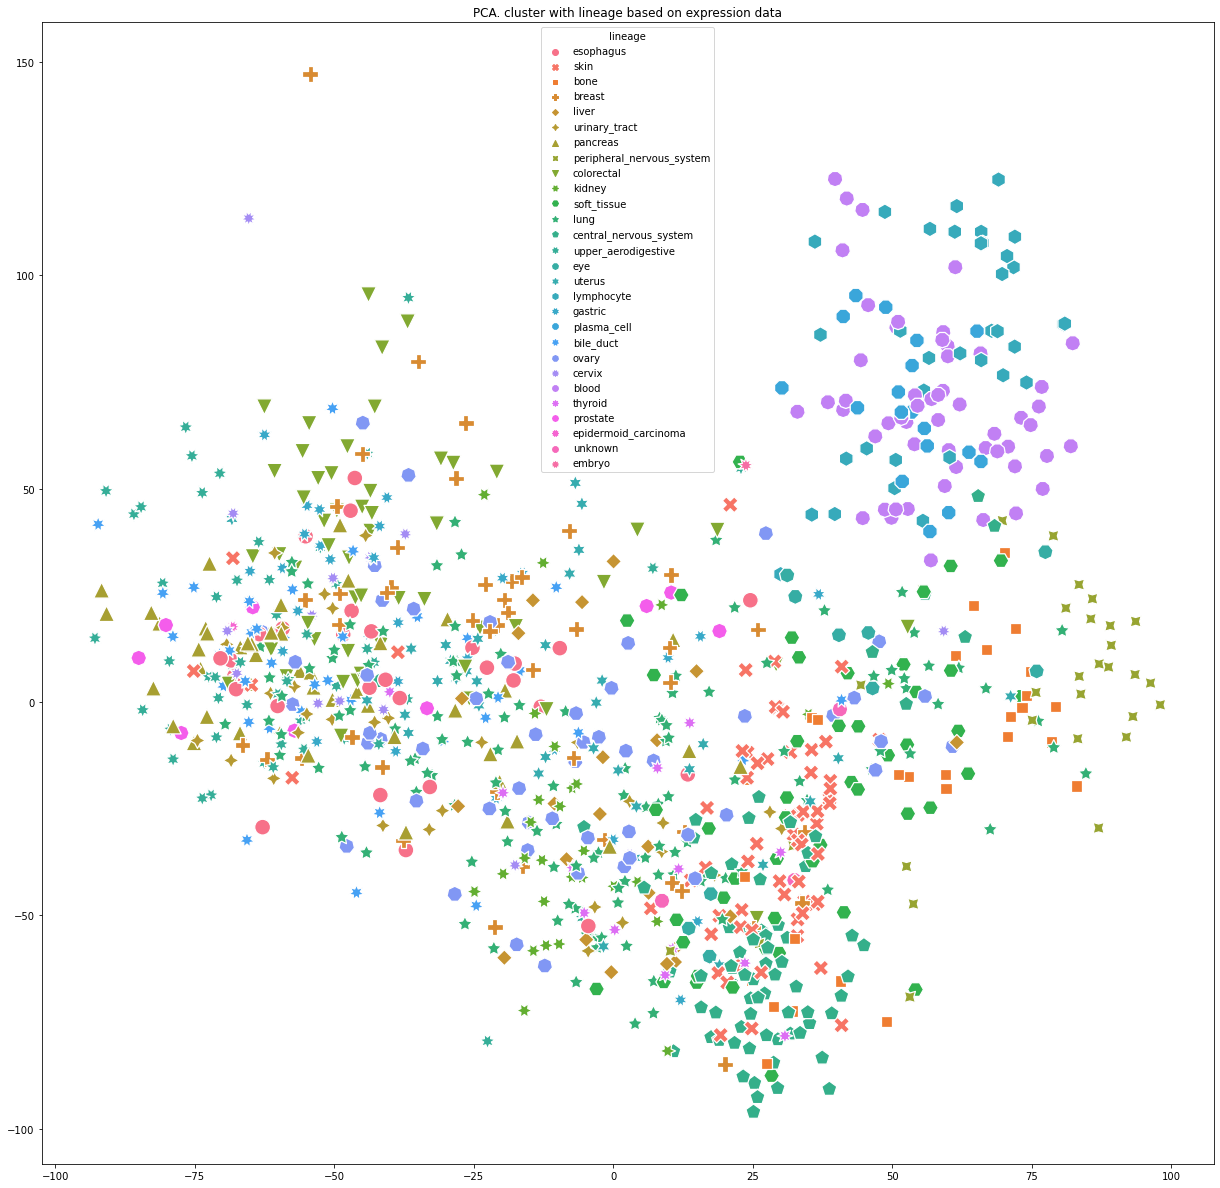

In [63]:
X = exp2_s.values.T

t0 = time.time()
# svd = TruncatedSVD( n_components=2, n_iter=7, random_state=42)
reducer1 = PCA()# n_components=2)
r = reducer1.fit_transform(X)
print(time.time() - t0, 'seconds passed')

t0 = time.time()
plt.figure(figsize = (21,21))
sns.scatterplot(x=r[:,0],y=r[:,1] , hue= y1, style =y1 , s = 250 )
plt.title('PCA. cluster with lineage based on expression data')

In [589]:
y

DepMap_ID
ACH-000665                      lung
ACH-000336                     blood
ACH-000090                  prostate
ACH-000452                 esophagus
ACH-000025    central_nervous_system
                       ...          
ACH-000001                     ovary
ACH-000155                  pancreas
ACH-001396                    breast
ACH-000181       upper_aerodigestive
ACH-000459                    kidney
Name: lineage, Length: 1003, dtype: object

# T-SNE

C:\Users\10096\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'TSNE. cluster with lineage based on ko data')

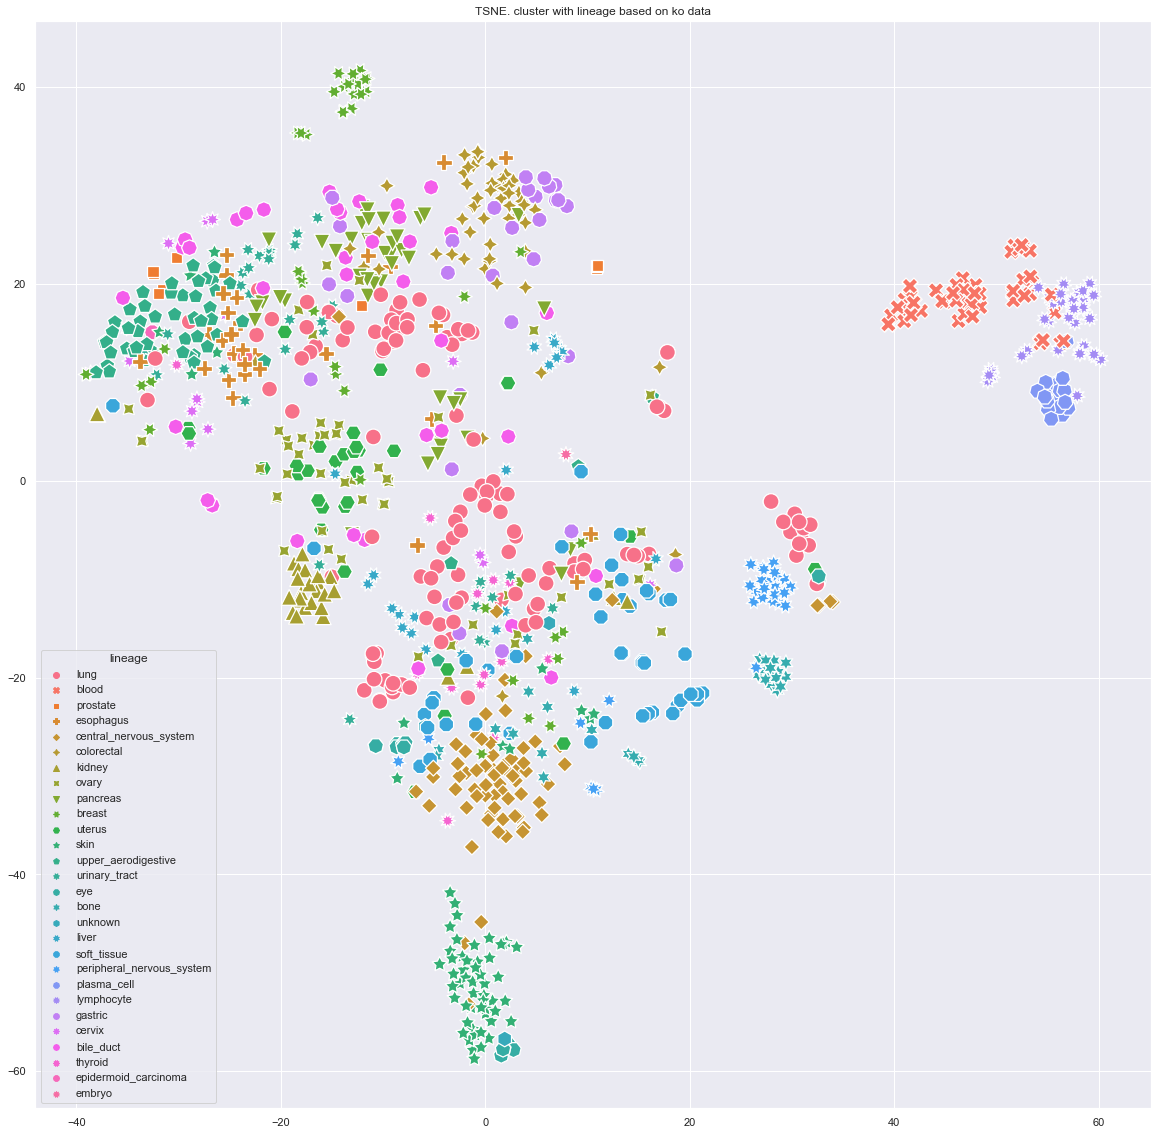

In [606]:
from sklearn.manifold import TSNE
import seaborn as sns
#scaler = StandardScaler()

# Scale the data using the StandardScaler object
#exp_scaled = scaler.fit_transform(exp_s.T)
X = exp2_s.values.T
sns.set(rc={'figure.figsize':(20,20)})
palette = sns.color_palette("bright", 28)
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y1, style =y1 , s = 250)
plt.title('TSNE. cluster with lineage based on expression data')

C:\Users\10096\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'TSNE. cluster with lineage based on ko data')

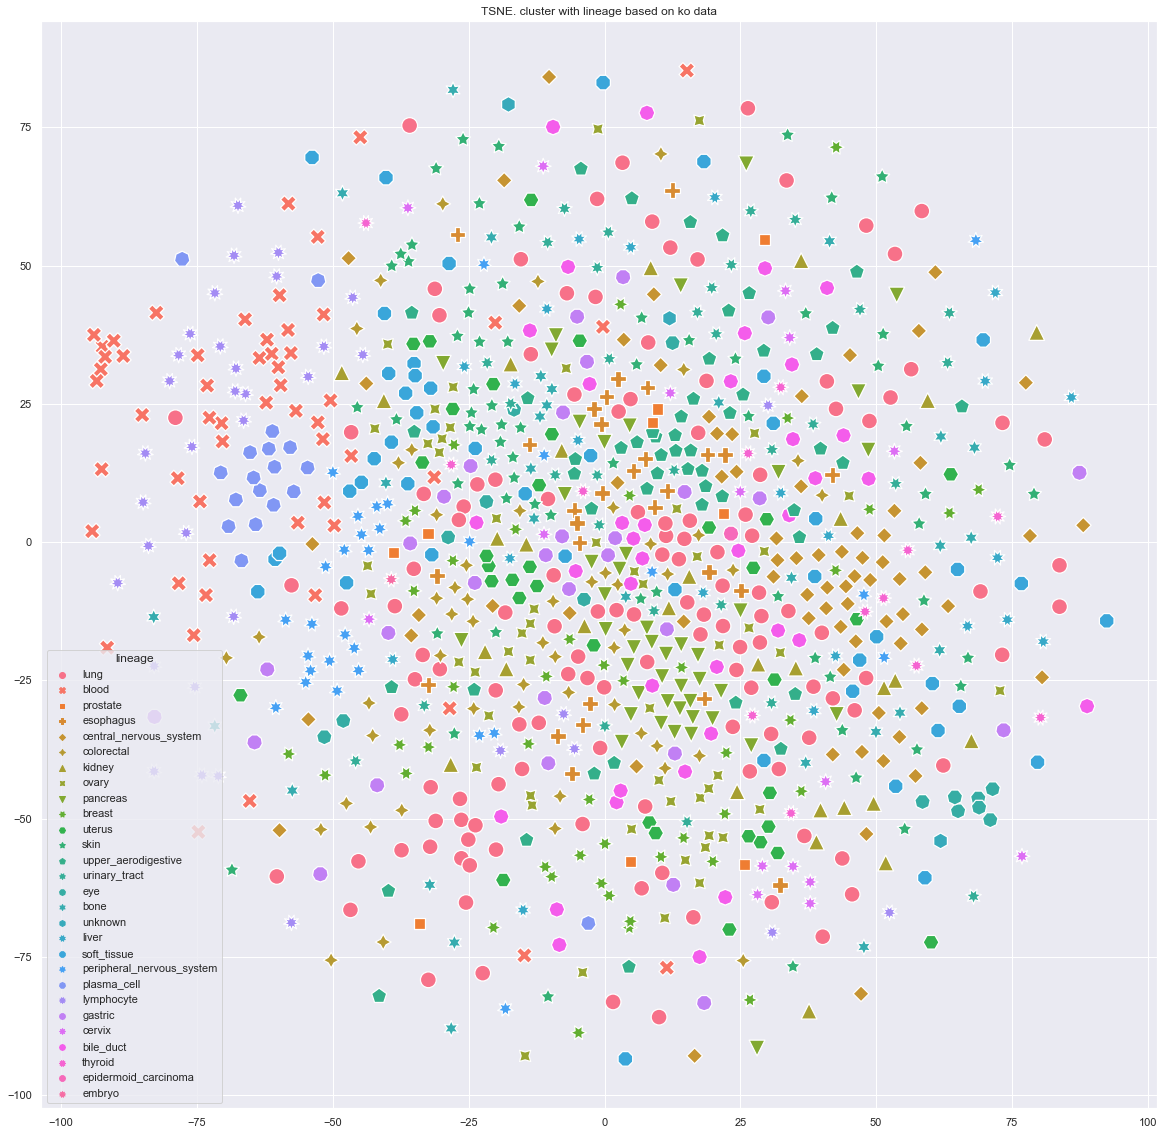

In [602]:
#exp_scaled = scaler.fit_transform(ac_s.T)
sns.set(rc={'figure.figsize':(20,20)})
palette = sns.color_palette("bright", 28)
tsne = TSNE()
X_embedded = tsne.fit_transform(ac_s.T.values)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, style =y , s = 250)
plt.title('TSNE. cluster with lineage based on ko data')

C:\Users\10096\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'TSNE. cluster with lineage based on ko data + expression data')

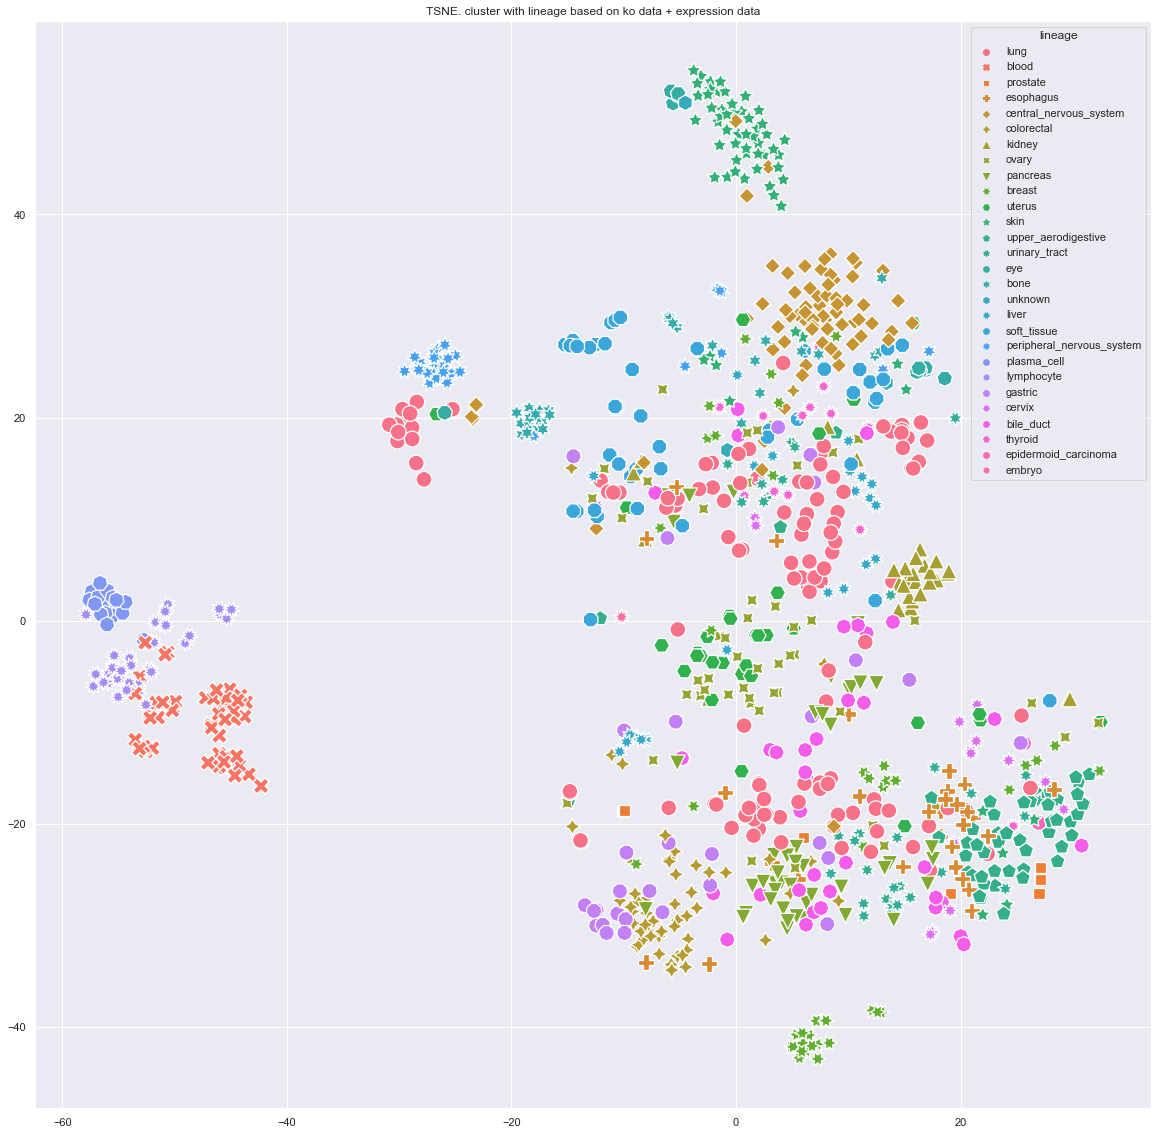

In [605]:
expac_s = pd.concat([exp_s, ac_s])
X = expac_s.values.T
#scaler = StandardScaler()

#X = scaler.fit_transform(expac_s.values.T)


exp_scaled = scaler.fit_transform(ac_s.T)
sns.set(rc={'figure.figsize':(20,20)})
palette = sns.color_palette("bright", 28)
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, style =y , s = 250)
plt.title('TSNE. cluster with lineage based on ko data + expression data')

In [ ]:
exp_s

# Machine Learning

In [ ]:
y

In [608]:
le = LabelEncoder()

# Fit the LabelEncoder object on the list of labels
le.fit(y)

# Transform the list of labels to a numpy array of numbers
y_encoded = le.transform(y)

# Print the encoded labels
print(y_encoded)
y_decoded = le.inverse_transform(y_encoded)

# Print the decoded labels
print(y_decoded)

[14  1 20 ...  3 25 12]
['lung' 'blood' 'prostate' ... 'breast' 'upper_aerodigestive' 'kidney']


In [609]:
y

DepMap_ID
ACH-000665                      lung
ACH-000336                     blood
ACH-000090                  prostate
ACH-000452                 esophagus
ACH-000025    central_nervous_system
                       ...          
ACH-000001                     ovary
ACH-000155                  pancreas
ACH-001396                    breast
ACH-000181       upper_aerodigestive
ACH-000459                    kidney
Name: lineage, Length: 1003, dtype: object

# class selection

In [638]:
# Convert the label set y to a numpy array
y_array = np.array(y_encoded)

# Count the occurrences of each class in y
class_counts = np.bincount(y_array)
min_instances=30
# Get the indices of the classes that have count below min_instances
indices_to_drop = np.where(class_counts < min_instances)[0]

# Create a mask to filter out instances of the dropped classes
mask = np.isin(y_array, indices_to_drop, invert=True)

# Filter out instances of the dropped classes from y
y_filtered = y_array[mask]

# Print the updated count of each class in y_filtered
class_counts_filtered = np.bincount(y_filtered)
print(class_counts_filtered)

[ 37  55   0  45  72   0  55   0   0   0   0  30   0   0 130  36  53  45
  30   0   0  66  47   0   0  52  32  34]


In [643]:
ac_data_filtered=ac_s.T[mask].T
exp_data_filtered=exp_s.T[mask].T

In [644]:
ac_data_filtered.shape

(17440, 819)

In [647]:
exp_data_filtered.shape

(17440, 819)

In [645]:
y_filtered.shape

(819,)

# a）Logistic Regression

In [654]:
exp_np = exp_s.to_numpy().T

In [655]:
exp_np.shape

(1003, 17440)

In [628]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
#scaler = StandardScaler()


#exp_data_scaled = scaler.fit_transform(exp_np)
X_train, X_test, y_train, y_test = train_test_split(exp_np, y_encoded, test_size=0.2, random_state=42)


model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Linear regresison with expression data- Accuracy:", accuracy)

C:\Users\10096\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear regresison with expression data- Accuracy: 0.7910447761194029


In [653]:
expac_s = pd.concat([exp_s, ac_s])
expac_np = expac_s.to_numpy().T

In [656]:
expac_np.shape

(1003, 34880)

In [627]:
scaler = StandardScaler()


comb_data_scaled = scaler.fit_transform(expac_np)
X_train, X_test, y_train, y_test = train_test_split(expac_np, y_encoded, test_size=0.2, random_state=42)


model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Linear regresison with ko data+expression data- Accuracy:", accuracy)

C:\Users\10096\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear regresison with ko data+expression data- Accuracy: 0.8059701492537313


# Feature Importance

In [ ]:
dfs_s=pd.concat([ac_data_filtered, exp_data_filtered])
dfs_np=dfs_s.to_numpy().T

In [754]:
X_train, X_test, y_train, y_test = train_test_split(expac_np, y_encoded, test_size=0.2, random_state=42)


model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Get the feature importance scores from the model's coefficients
importance = abs(model.coef_[0])

# Create a dataframe of feature names and importance scores
feature_importance = pd.DataFrame({'Feature': expac_s.T.columns, 'Importance': importance})

# Sort the features by importance score
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Print the top 10 features
print(feature_importance.head(10))

C:\Users\10096\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


       Feature  Importance
4849      6696    0.031472
6101      8581    0.029257
546        725    0.024325
9170     80201    0.024050
4182      5836    0.023843
6135      8644    0.023732
5695      7837    0.022940
3421      4837    0.022639
16259   389376    0.021663
6380      8942    0.021607


In [752]:
expac_s.T.columns

Int64Index([     1,      2, 131076,      9,     10,     12,     13,     14,
                15,     16,
            ...
            196541, 163778, 163782, 163786, 131034,   6508, 327657, 201895,
             26048,  26050],
           dtype='int64', length=34880)

In [652]:
X_train, X_test, y_train, y_test = train_test_split(dfs_np, y_filtered, test_size=0.2, random_state=42)
model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Linear regresison with ko data+expression data- Accuracy:", accuracy)

C:\Users\10096\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear regresison with ko data+expression data- Accuracy: 0.774390243902439


In [629]:
ac_np = ac_s.to_numpy().T

In [630]:
ac_np.shape

(1003, 17440)

In [631]:
X_train, X_test, y_train, y_test = train_test_split(ac_np, y_encoded, test_size=0.2, random_state=42)


model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Linear regresison with ko data- Accuracy:", accuracy)


C:\Users\10096\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear regresison with ko data- Accuracy: 0.6666666666666666


In [668]:
X_train, X_test, y_train, y_test = train_test_split(expac_np, y_encoded, test_size=0.2, random_state=42)

# Define the number of features to select
num_features = 8000

# Perform feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=num_features)

scaler = StandardScaler()

# Apply feature selection and scaling to training data
X_train_selected = selector.fit_transform(X_train, y_train)
#X_train_scaled = scaler.fit_transform(X_train_selected)

# Apply feature selection and scaling to test data
X_test_selected = selector.transform(X_test)
#X_test_scaled = scaler.transform(X_test_selected)


model = LogisticRegression()

# Train the model on the training set
model.fit(X_train_selected, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_selected)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Linear regresison with ko+expression data with feature selection- Accuracy:", accuracy)





C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [9875] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Linear regresison with ko+expression data with feature selection- Accuracy: 0.8059701492537313


C:\Users\10096\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Parameter Tuning

In [692]:
from sklearn.model_selection import GridSearchCV

# Define the number of features to select
num_features = 8000
X_train, X_test, y_train, y_test = train_test_split(expac_np, y_encoded, test_size=0.2, random_state=42)
# Perform feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=num_features)

scaler = StandardScaler()

# Apply feature selection and scaling to training data
X_train_selected = selector.fit_transform(X_train, y_train)

# Apply feature selection and scaling to test data
X_test_selected = selector.transform(X_test)


# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Define the logistic regression model
model = LogisticRegression()

# Define the grid search object
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train_selected, y_train)

# Print the best parameters found by grid search
print("Best parameters: ", grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the testing set
y_pred = best_model.predict(X_test_selected)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Linear regresison with ko+expression data with feature selection- Accuracy:", accuracy)


C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [9875] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\10096\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Best parameters:  {'C': 0.001}
Linear regresison with ko+expression data with feature selection- Accuracy: 0.7512437810945274


C:\Users\10096\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [667]:
X_train_selected.shape

(802, 8000)

In [663]:
expac_np.shape

(1003, 34880)

# b)Random Forest

In [693]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(expac_np, y_encoded, test_size=0.2, random_state=42)

# Define the number of features to select
num_features = 8000

# Perform feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=num_features)

scaler = StandardScaler()

# Apply feature selection and scaling to training data
X_train_selected = selector.fit_transform(X_train, y_train)
X_train_scaled = scaler.fit_transform(X_train_selected)

# Apply feature selection and scaling to test data
X_test_selected = selector.transform(X_test)
X_test_scaled = scaler.transform(X_test_selected)

# Create Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
rf.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = rf.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest with ko+expression data with feature selection- Accuracy:", accuracy)


C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [9875] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Random Forest with ko+expression data with feature selection- Accuracy: 0.6368159203980099


# c)Neuraul Network

C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [9875] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Epoch 1/20
26/26 [==============================] - 1s 12ms/step - loss: 2.2173 - accuracy: 0.4264 - val_loss: 1.5076 - val_accuracy: 0.5323
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.9018 - accuracy: 0.7419 - val_loss: 1.5361 - val_accuracy: 0.6368
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.4610 - accuracy: 0.8753 - val_loss: 1.1546 - val_accuracy: 0.7065
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1553 - accuracy: 0.9651 - val_loss: 1.1138 - val_accuracy: 0.7214
Epoch 5/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0796 - accuracy: 0.9863 - val_loss: 1.2926 - val_accuracy: 0.6866
Epoch 6/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0621 - accuracy: 0.9888 - val_loss: 1.1645 - val_accuracy: 0.7214
Epoch 7/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0501 - accuracy: 0.9925 - val_loss: 1.1692 - val_accuracy: 0.7463
Epoch 8/20
26/26 [=

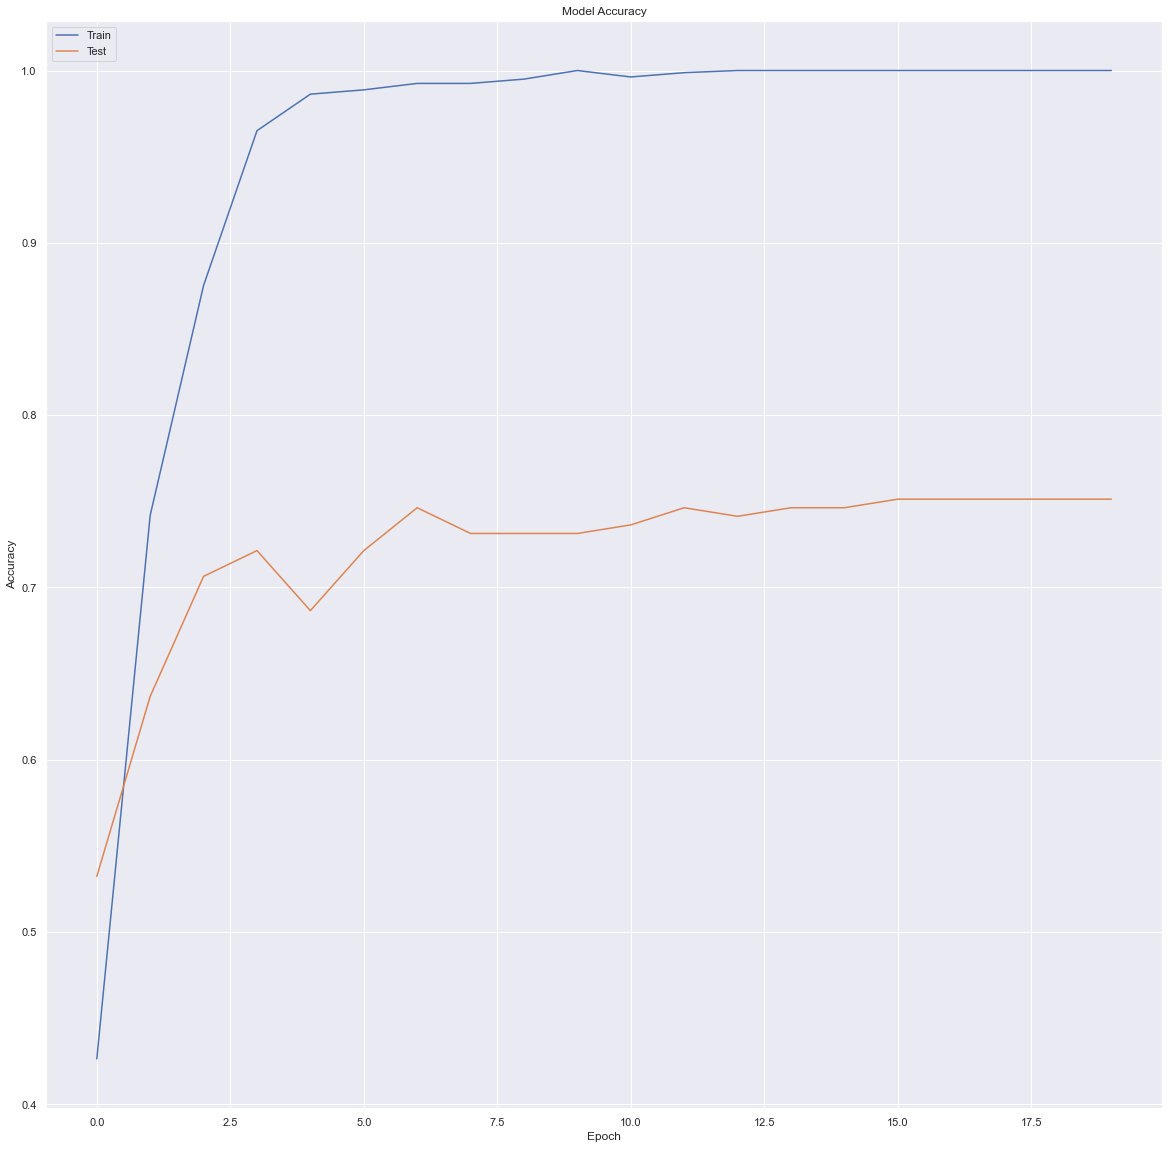

In [691]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
X_train, X_test, y_train, y_test = train_test_split(expaccn_np, y1_encoded, test_size=0.2, random_state=42)

# Define the number of features to select
num_features = 8000

# Perform feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=num_features)

# Scale the data
scaler = StandardScaler()

# Apply feature selection and scaling to training data
X_train_selected = selector.fit_transform(X_train, y_train)
X_train_scaled = scaler.fit_transform(X_train_selected)
#
# Apply feature selection and scaling to test data
X_test_selected = selector.transform(X_test)
X_test_scaled = scaler.transform(X_test_selected)

# Convert y_train and y_test to categorical data
num_classes = len(np.unique(y_train))
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

# Build a neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history =model.fit(X_train_scaled, y_train_cat, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test_cat))
accuracy = model.evaluate(X_test_scaled, y_test_cat)[1]
print("Neural network with expression + KO +copynumber Data Accuracy:", accuracy)

# Plot the learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Model Tuning

In [690]:
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the number of features to select
num_features = 8000

# Perform feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=num_features)

# Scale the data
scaler = StandardScaler()

# Load the data
X_train, X_test, y_train, y_test = train_test_split(expac_np, y_encoded, test_size=0.2, random_state=42)

# Apply feature selection and scaling to training data
X_train_selected = selector.fit_transform(X_train, y_train)
X_train_scaled = scaler.fit_transform(X_train_selected)

# Apply feature selection and scaling to test data
X_test_selected = selector.transform(X_test)
X_test_scaled = scaler.transform(X_test_selected)

# Convert y_train and y_test to categorical data
num_classes = len(np.unique(y_train))
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

# Define the neural network model
def create_model(neurons=64, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(num_features,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the grid of hyperparameters to search over
param_grid = {'neurons': [32, 64, 128],
              'dropout_rate': [0.0, 0.1, 0.2]}

# Create a Keras classifier object
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

# Create a GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_scaled, y_train_cat)

# Print the best hyperparameters and accuracy
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)


C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [9875] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\10096\AppData\Local\Temp/ipykernel_4940/909616140.py:52: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)


Best Parameters:  {'dropout_rate': 0.0, 'neurons': 64}
Best Accuracy:  0.7007378935813904


C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [9875] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Epoch 1/50
26/26 [==============================] - 1s 13ms/step - loss: 2.1474 - accuracy: 0.4377 - val_loss: 1.4492 - val_accuracy: 0.5821
Epoch 2/50
26/26 [==============================] - 0s 7ms/step - loss: 0.9552 - accuracy: 0.7307 - val_loss: 1.3594 - val_accuracy: 0.6368
Epoch 3/50
26/26 [==============================] - 0s 6ms/step - loss: 0.4710 - accuracy: 0.8791 - val_loss: 1.2285 - val_accuracy: 0.6816
Epoch 4/50
26/26 [==============================] - 0s 7ms/step - loss: 0.2777 - accuracy: 0.9327 - val_loss: 1.1896 - val_accuracy: 0.6915
Epoch 5/50
26/26 [==============================] - 0s 7ms/step - loss: 0.2746 - accuracy: 0.9451 - val_loss: 1.3529 - val_accuracy: 0.7065
Epoch 6/50
26/26 [==============================] - 0s 6ms/step - loss: 0.0846 - accuracy: 0.9751 - val_loss: 1.3640 - val_accuracy: 0.7114
Epoch 7/50
26/26 [==============================] - 0s 7ms/step - loss: 0.0520 - accuracy: 0.9875 - val_loss: 1.4568 - val_accuracy: 0.7015
Epoch 8/50
26/26 [=

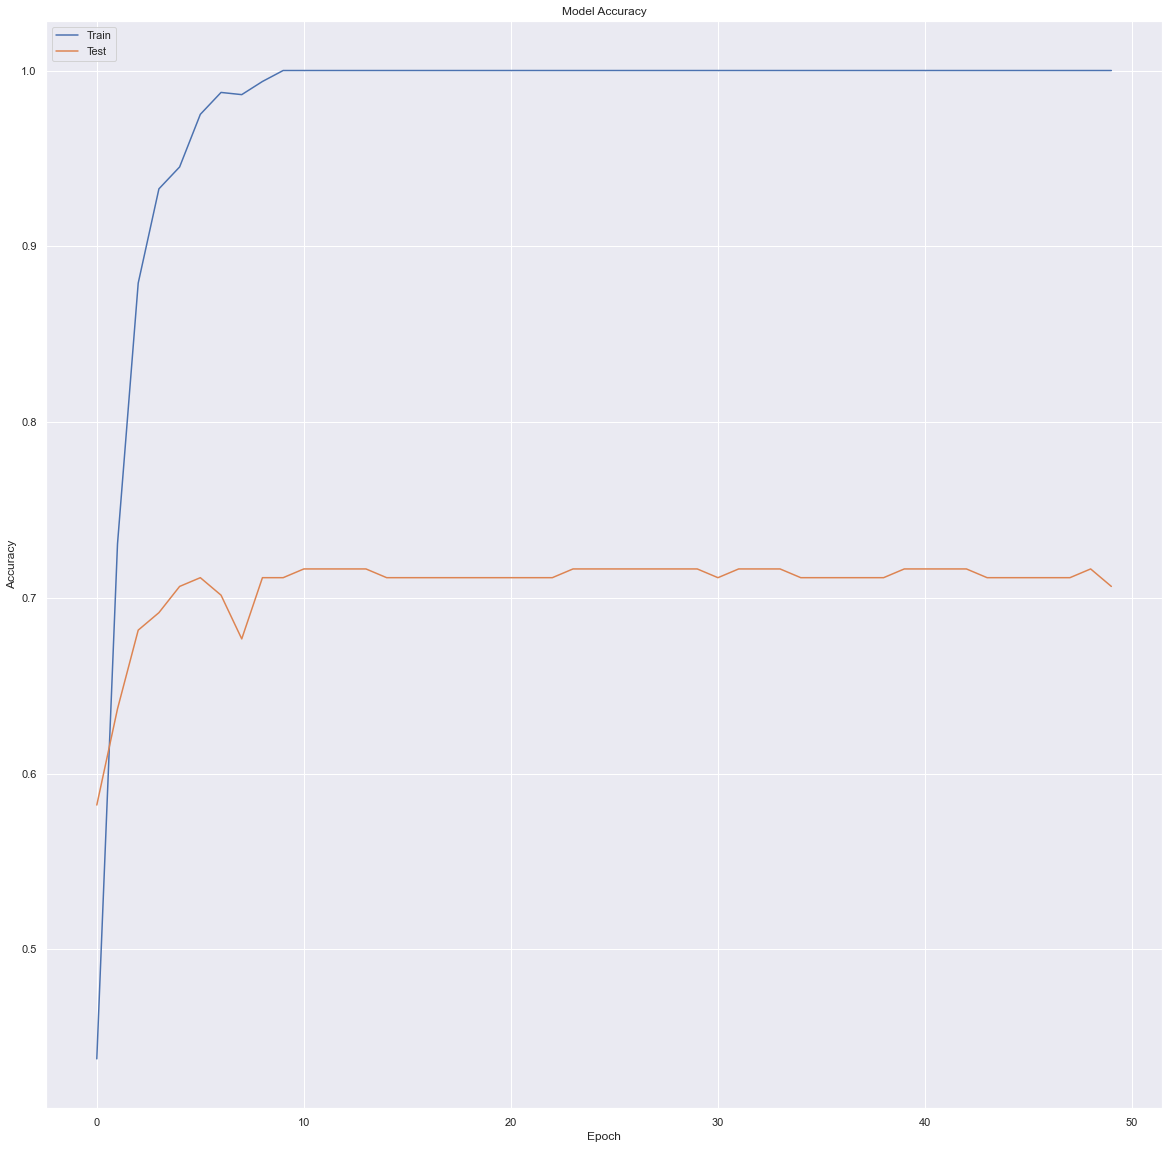

In [689]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
X_train, X_test, y_train, y_test = train_test_split(exp_np, y_encoded, test_size=0.2, random_state=42)

# Define the number of features to select
num_features = 8000

# Perform feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=num_features)

# Scale the data
scaler = StandardScaler()

# Apply feature selection and scaling to training data
X_train_selected = selector.fit_transform(X_train, y_train)
X_train_scaled = scaler.fit_transform(X_train_selected)
#
# Apply feature selection and scaling to test data
X_test_selected = selector.transform(X_test)
X_test_scaled = scaler.transform(X_test_selected)

# Convert y_train and y_test to categorical data
num_classes = len(np.unique(y_train))
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

# Build a neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history =model.fit(X_train_scaled, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_cat))
accuracy = model.evaluate(X_test_scaled, y_test_cat)[1]
print("Neural network with expression + KO Data Accuracy:", accuracy)

# Plot the learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [684]:
X_train.shape

(802, 34880)

# d)KNN

In [695]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(expac_np, y_encoded, test_size=0.2, random_state=42)

# Perform feature selection using ANOVA F-value
num_features = 8000
selector = SelectKBest(f_classif, k=num_features)

# Scale the data
scaler = StandardScaler()

# Apply feature selection and scaling to training data
X_train_selected = selector.fit_transform(X_train, y_train)
X_train_scaled = scaler.fit_transform(X_train_selected)

# Apply feature selection and scaling to test data
X_test_selected = selector.transform(X_test)
X_test_scaled = scaler.transform(X_test_selected)

# KNN model
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)




C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [9875] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


KNN Accuracy: 0.6766169154228856


# E)SVM

In [696]:
# SVM model
svm = SVC()
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)



SVM Accuracy: 0.6766169154228856


# F)naive Bayes

In [697]:
# Naive Bayes model
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)

Naive Bayes Accuracy: 0.4527363184079602


# Data Auggmentation with CopyNumber

In [13]:
exp2 = exp.copy()
ac2 = achilles.copy()
cop2=cn.copy()
si2=sample_info.T.copy()
exp2_genes = set(exp2.index)
ac2_genes = set(ac2.index)
cop2_genes=set(cop2.index)
shared2_genes = ac2_genes.intersection(exp2_genes)
shared2_genes=shared2_genes.intersection(cop2_genes)
common2_cols = list(set(exp2.iloc[0]) & set(achilles.iloc[0])& set(cn.iloc[0]))


In [14]:
common2_cols = list(set(exp2.iloc[0]) & set(achilles.iloc[0])& set(cn.iloc[0]))  # get common columns

In [15]:
exp2

,0,1,2,3,4,5,6,7,8,9,...,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405
Unnamed: 0,ACH-001113,ACH-001289,ACH-001339,ACH-001538,ACH-000242,ACH-000708,ACH-000327,ACH-000233,ACH-000461,ACH-000705,...,ACH-001578,ACH-000036,ACH-000973,ACH-001128,ACH-000750,ACH-000285,ACH-002669,ACH-001858,ACH-001997,ACH-000052
7105,4.331992,4.566815,3.15056,5.08534,6.729145,4.272023,3.337711,0.056584,4.01614,4.411426,...,6.344828,4.018812,4.328406,5.994806,3.533563,0.056584,3.109361,4.390943,5.057017,4.247928
64102,0.0,0.584963,0.0,0.0,0.0,0.189034,0.0,0.0,0.0,0.0,...,3.400538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8813,7.364397,7.106537,7.379032,7.154109,6.537607,7.022923,5.927185,6.093602,6.533875,6.412443,...,7.211207,6.700578,7.058749,6.238787,6.488322,6.604071,7.031219,7.013127,7.814935,6.174127
57147,2.792855,2.543496,2.333424,2.545968,2.456806,2.555816,1.944858,3.970854,2.226509,2.364572,...,2.533563,2.137504,1.891419,2.304511,1.823749,3.264536,1.541019,1.887525,2.538538,2.316146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728929,0.0,0.0,0.0,0.0,0.0,0.0,0.124328,0.0,0.0,0.0,...,0.0,0.0,0.042644,0.0,0.0,0.0,0.0,0.0,0.0,0.042644
2831,0.275007,0.014355,0.084064,0.028569,0.464668,0.0,0.176323,0.0,0.014355,0.042644,...,0.028569,0.014355,0.014355,0.0,0.124328,0.0,0.014355,1.464668,0.0,0.0
100506888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056584,0.028569,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162699,0.0,0.0,0.0,0.0,0.0,0.0,0.084064,0.0,0.0,0.0,...,0.0,0.0,0.042644,0.0,0.0,0.475085,0.0,0.0,0.0,0.176323


In [16]:


exp2.columns = exp2.iloc[0]
exp2=exp2.iloc[1: , :]
exp2=exp2[common2_cols]

ac2.columns = ac2.iloc[0]
ac2=ac2.iloc[1: , :]
ac2=ac2[common2_cols]

cop2.columns = cop2.iloc[0]
cop2=cop2.iloc[1: , :]
cop2=cop2[common2_cols]


si2.columns = si2.iloc[0]
si2=si2.iloc[1: , :]
si2=si2[common2_cols].T
y1=si2.lineage


In [17]:
exp2

Unnamed: 0,ACH-000605,ACH-000899,ACH-000039,ACH-000330,ACH-000217,ACH-000834,ACH-000266,ACH-001302,ACH-002024,ACH-000375,...,ACH-000832,ACH-000872,ACH-000442,ACH-000599,ACH-000452,ACH-000160,ACH-000348,ACH-000311,ACH-001029,ACH-000296
7105,4.379205,3.972693,4.393004,3.485427,3.192194,5.683416,4.867896,4.575917,2.746313,2.85997,...,3.650765,4.778734,2.446256,4.529196,4.595146,2.835924,2.956057,3.629939,6.038261,4.708187
64102,0.0,0.0,0.028569,0.028569,0.0,0.0,0.028569,0.0,0.0,0.028569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214125,0.163499
8813,6.473949,7.490008,6.115408,6.984134,6.398316,7.125155,6.478648,6.638364,7.272583,6.192983,...,6.544578,6.488804,7.18299,6.856737,7.911272,6.361768,7.232661,6.394548,5.525443,6.654493
57147,2.207893,3.534809,2.403268,2.560715,2.263034,1.963474,2.316146,2.521051,2.344828,2.513491,...,2.500802,2.825786,1.811471,1.722466,2.330558,1.550901,2.244887,1.831877,2.863938,2.584963
55732,4.098453,4.419539,4.598722,3.806324,3.522307,2.523562,3.654206,3.463361,3.130931,3.252476,...,4.084915,3.617063,3.666757,3.646163,3.516015,3.257011,3.204767,3.463361,4.892877,4.341274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728929,0.0,0.250962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.014355,0.014355,0.0,0.0,0.028569,0.0,0.014355,0.0,0.0
2831,0.422233,0.014355,0.422233,0.0,0.0,0.536053,0.014355,0.0,0.0,0.0,...,0.137504,0.0,0.163499,0.0,1.516015,0.0,0.594549,0.084064,0.378512,0.0
100506888,0.056584,0.0,0.286881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.014355,0.014355,0.0,0.0,0.028569,0.070389,0.014355,0.0,0.0
162699,0.0,0.250962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.014355,0.014355,0.0,0.0,0.0,0.0,0.014355,0.070389,0.0


In [18]:
ac2

Unnamed: 0,ACH-000605,ACH-000899,ACH-000039,ACH-000330,ACH-000217,ACH-000834,ACH-000266,ACH-001302,ACH-002024,ACH-000375,...,ACH-000832,ACH-000872,ACH-000442,ACH-000599,ACH-000452,ACH-000160,ACH-000348,ACH-000311,ACH-001029,ACH-000296
1,-0.052689,0.172428,0.019655,0.005766,-0.007836,-0.02055,-0.01664,-0.015486,-0.109538,-0.313158,...,0.08721,-0.019954,0.057533,0.006096,-0.025577,-0.196564,-0.015635,-0.096751,0.020985,0.044822
29974,-0.167935,0.103112,0.194146,-0.353113,-0.170229,-0.294194,0.053615,0.190076,-0.20018,-0.276735,...,-0.296085,-0.111044,0.205212,-0.021306,-0.152326,0.09312,0.031735,0.126132,-0.129109,-0.143067
2,-0.061728,0.143885,0.01766,0.156967,0.088705,-0.021331,-0.090508,0.016583,0.105802,-0.172022,...,0.025632,0.010295,-0.154406,0.082028,-0.00668,-0.02003,-0.052826,-0.091989,0.054327,-0.185542
144568,0.172637,0.254438,0.450722,0.071879,0.164226,-0.034227,0.08836,0.354901,0.150911,-0.102884,...,0.010712,0.011115,0.239753,-0.033871,-0.022273,0.0226,0.051919,0.072637,0.085912,0.111129
127550,-0.142172,-0.145542,0.221531,0.05117,-0.277361,-0.01213,-0.01584,-0.068781,-0.290477,0.132969,...,0.011603,-0.165481,-0.325557,-0.076938,-0.097336,-0.21019,-0.179824,-0.112108,-0.090387,-0.047334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440590,-0.076657,0.143467,-0.11957,-0.147533,-0.041633,-0.109131,0.043926,-0.164154,-0.055778,0.054312,...,-0.067546,-0.154859,-0.124188,0.072291,-0.076944,0.0303,-0.069334,-0.11892,-0.005998,-0.264475
79699,-0.166538,0.034243,-0.226804,-0.215423,-0.119468,-0.196838,-0.146042,-0.302954,-0.267094,-0.181971,...,-0.124536,-0.189301,-0.118732,-0.035721,-0.11315,-0.077622,-0.129552,-0.157475,-0.180102,-0.462885
7791,0.009123,0.013022,0.001519,-0.219631,0.074899,0.176475,0.015786,-0.104479,-0.261838,-0.496452,...,0.042441,-0.074308,0.09129,0.063396,-0.076489,-0.03364,-0.102228,0.267055,-0.022874,-0.06378
23140,-0.045206,0.105345,-0.043261,-0.164822,-0.160647,-0.101565,-0.084142,0.204961,-0.128344,0.016271,...,0.080161,0.016549,-0.117184,-0.078222,-0.199976,-0.317878,-0.050524,0.003458,-0.143901,-0.136798


In [19]:
cop2

Unnamed: 0,ACH-000605,ACH-000899,ACH-000039,ACH-000330,ACH-000217,ACH-000834,ACH-000266,ACH-001302,ACH-002024,ACH-000375,...,ACH-000832,ACH-000872,ACH-000442,ACH-000599,ACH-000452,ACH-000160,ACH-000348,ACH-000311,ACH-001029,ACH-000296
84771,0.865729,0.914631,1.07955,1.437443,1.001449,0.76639,1.228353,0.622905,1.10341,0.987466,...,1.006153,0.778963,1.011784,0.826332,1.380436,1.006183,1.033022,0.888644,0.987094,1.130527
653635,0.865729,0.914631,1.07955,1.437443,1.001449,0.76639,1.228353,0.622905,1.10341,0.987466,...,1.006153,0.778963,1.011784,0.826332,1.380436,1.006183,1.033022,0.888644,0.987094,1.130527
102466751,0.865729,0.914631,1.07955,1.437443,1.001449,0.76639,1.228353,0.622905,1.10341,0.987466,...,1.006153,0.778963,1.011784,0.826332,1.380436,1.006183,1.033022,0.888644,0.987094,1.130527
100302278,0.865729,0.914631,1.07955,1.437443,1.001449,0.76639,1.228353,0.622905,1.10341,0.987466,...,1.006153,0.778963,1.011784,0.826332,1.380436,1.006183,1.033022,0.888644,0.987094,1.130527
645520,0.865729,0.914631,1.07955,1.437443,1.001449,0.76639,1.228353,0.622905,1.10341,0.987466,...,1.006153,0.778963,1.011784,0.826332,1.380436,1.006183,1.033022,0.888644,0.987094,1.130527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442868,0.0,0.52743,0.000059,0.0,0.0,0.0,0.420957,0.0,0.0,0.0,...,0.0,0.007975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
474150,0.0,0.52743,0.000059,0.0,0.0,0.0,0.420957,0.0,0.0,0.0,...,0.0,0.007975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114758,0.0,0.52743,0.000059,0.0,0.0,0.0,0.420957,0.0,0.0,0.0,...,0.0,0.007975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9085,0.0,0.52743,0.000059,0.0,0.0,0.0,0.420957,0.0,0.0,0.0,...,0.0,0.007975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
y1

DepMap_ID
ACH-000605      esophagus
ACH-000899           skin
ACH-000039           bone
ACH-000330         breast
ACH-000217          liver
                 ...     
ACH-000160    soft_tissue
ACH-000348           skin
ACH-000311           lung
ACH-001029           bone
ACH-000296     colorectal
Name: lineage, Length: 997, dtype: object

In [21]:
#my_exp = exp.copy()
keep2_genes = set()
for g in shared2_genes:
    #if g in keep_common_genes:
        keep2_genes.add(g)

keep2_genes.remove('Unnamed: 0')
        
exp2_s = exp2
exp2_s.columns.name=None
exp2_s = exp2_s.T[keep2_genes].T
exp2_s = exp2_s[~exp2_s.index.duplicated(keep='first')]
ac2_s = ac2
ac2_s.columns.name=None
ac2_s = ac2_s.T[keep2_genes].T
cop2_s = cop2
cop2_s.columns.name=None
cop2_s = cop2_s.T[keep2_genes].T
cop2_s = cop2_s[~cop2_s.index.duplicated(keep='first')]




In [22]:
exp2_s.shape

(17440, 997)

In [23]:
ac2_s.shape


(17440, 997)

In [24]:
cop2_s.shape

(17440, 997)

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Fit the LabelEncoder object on the list of labels
le.fit(y1)

# Transform the list of labels to a numpy array of numbers
y1_encoded = le.transform(y1)

# Print the encoded labels
#print(y_encoded)
y1_decoded = le.inverse_transform(y1_encoded)

# Print the decoded labels
print(y1_decoded)

['esophagus' 'skin' 'bone' 'breast' 'liver' 'urinary_tract' 'pancreas'
 'peripheral_nervous_system' 'colorectal' 'kidney' 'colorectal'
 'soft_tissue' 'lung' 'central_nervous_system' 'upper_aerodigestive'
 'peripheral_nervous_system' 'central_nervous_system' 'eye' 'uterus'
 'lung' 'central_nervous_system' 'lymphocyte' 'gastric' 'lymphocyte'
 'lung' 'upper_aerodigestive' 'central_nervous_system' 'bone' 'colorectal'
 'upper_aerodigestive' 'lung' 'plasma_cell' 'central_nervous_system'
 'central_nervous_system' 'skin' 'peripheral_nervous_system' 'breast'
 'upper_aerodigestive' 'bile_duct' 'gastric' 'central_nervous_system'
 'uterus' 'upper_aerodigestive' 'ovary' 'cervix' 'esophagus' 'blood'
 'bone' 'upper_aerodigestive' 'bone' 'ovary' 'central_nervous_system'
 'kidney' 'esophagus' 'ovary' 'urinary_tract' 'blood' 'blood'
 'upper_aerodigestive' 'bile_duct' 'skin' 'blood' 'eye' 'lung' 'ovary'
 'kidney' 'lung' 'ovary' 'pancreas' 'urinary_tract' 'colorectal' 'blood'
 'colorectal' 'ovary' 'bile_d

In [26]:
expaccn_s = pd.concat([exp2_s, ac2_s,cop2_s])
expaccn_np = expaccn_s.to_numpy().T

In [27]:
cop2_np= cop2_s.to_numpy().T

In [ ]:
expaccn_np.shape

In [726]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
#scaler = StandardScaler()


#exp_data_scaled = scaler.fit_transform(exp_np)
X_train, X_test, y_train, y_test = train_test_split(expaccn_np, y1_encoded, test_size=0.2, random_state=42)


model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Linear regresison with expression+ko+copy number data- Accuracy:", accuracy)

C:\Users\10096\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear regresison with expression data- Accuracy: 0.755


In [732]:
X_train, X_test, y_train, y_test = train_test_split(expaccn_np, y1_encoded, test_size=0.2, random_state=42)

# Define the number of features to select
num_features = 35000

# Perform feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=num_features)

scaler = StandardScaler()

# Apply feature selection and scaling to training data
X_train_selected = selector.fit_transform(X_train, y_train)
#X_train_scaled = scaler.fit_transform(X_train_selected)

# Apply feature selection and scaling to test data
X_test_selected = selector.transform(X_test)
#X_test_scaled = scaler.transform(X_test_selected)


model = LogisticRegression()

# Train the model on the training set
model.fit(X_train_selected, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_selected)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Linear regresison with ko+expression data with feature selection- Accuracy:", accuracy)





C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [9871] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\10096\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear regresison with ko+expression data with feature selection- Accuracy: 0.745


In [736]:
scaler = StandardScaler()


cop2_data_scaled = scaler.fit_transform(cop2_np)
X_train, X_test, y_train, y_test = train_test_split(cop2_data_scaled, y1_encoded, test_size=0.2, random_state=42)


model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Linear regresison with expression+ko+copy number data- Accuracy:", accuracy)

Linear regresison with expression+ko+copy number data- Accuracy: 0.315


C:\Users\10096\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [738]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(expaccn_np, y1_encoded, test_size=0.2, random_state=42)

# Perform feature selection using ANOVA F-value
num_features = 3000
selector = SelectKBest(f_classif, k=num_features)

# Scale the data
scaler = StandardScaler()

# Apply feature selection and scaling to training data
X_train_selected = selector.fit_transform(X_train, y_train)
X_train_scaled = scaler.fit_transform(X_train_selected)

# Apply feature selection and scaling to test data
X_test_selected = selector.transform(X_test)
X_test_scaled = scaler.transform(X_test_selected)

# KNN model
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)


C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [9871] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


KNN Accuracy: 0.655


In [739]:
svm = SVC()
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)


SVM Accuracy: 0.66


In [740]:


# Create Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
rf.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = rf.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest with ko+expression data with feature selection- Accuracy:", accuracy)

Random Forest with ko+expression data with feature selection- Accuracy: 0.66


In [741]:
# Naive Bayes model
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)

Naive Bayes Accuracy: 0.585


In [742]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
X_train, X_test, y_train, y_test = train_test_split(expaccn_np, y1_encoded, test_size=0.2, random_state=42)

# Define the number of features to select
num_features = 30000

# Perform feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=num_features)

# Scale the data
scaler = StandardScaler()

# Apply feature selection and scaling to training data
X_train_selected = selector.fit_transform(X_train, y_train)
X_train_scaled = scaler.fit_transform(X_train_selected)
#
# Apply feature selection and scaling to test data
X_test_selected = selector.transform(X_test)
X_test_scaled = scaler.transform(X_test_selected)

# Convert y_train and y_test to categorical data
num_classes = len(np.unique(y_train))
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

# Build a neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history =model.fit(X_train_scaled, y_train_cat, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test_cat))
accuracy = model.evaluate(X_test_scaled, y_test_cat)[1]
print("Neural network with expression + KO Data Accuracy:", accuracy)

# Plot the learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [9871] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


IndexError: index 27 is out of bounds for axis 1 with size 27

# Use Unsupervised Learning to Determine wether the cluster are unique

In [28]:
cop2_np = cop2_s.to_numpy().T
ac2_np = ac2_s.to_numpy().T
exp2_np = exp2_s.to_numpy().T

In [29]:
cop2_np.shape

(997, 17440)

In [30]:
expaccn_np.shape

(997, 52320)

# KMean

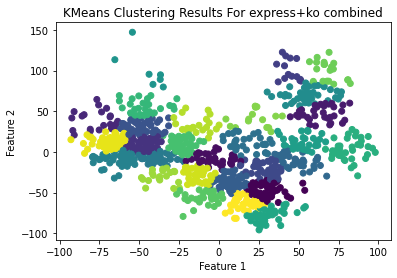

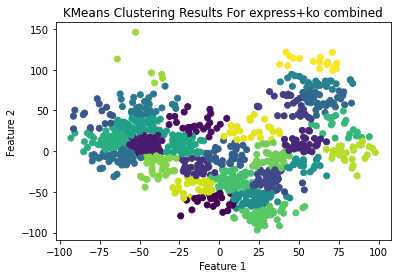

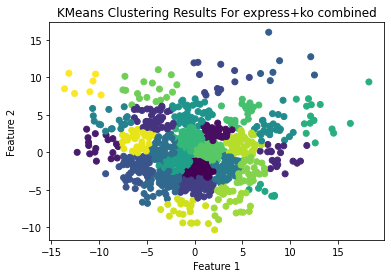

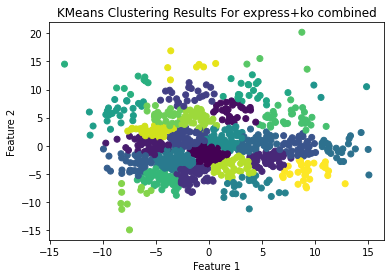

In [104]:
#X = (expaccn_np - np.mean(expaccn_np, axis=0)) / np.std(expaccn_np, axis=0)
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
# Apply K-means clustering
n_clu=len(np.unique(y1))
#kmeans = KMeans(n_clusters=n_clu, random_state=0)
pca = PCA(n_components=2)
expaccn_np_reduced = pca.fit_transform(expaccn_np)
exp2_np_reduced = pca.fit_transform(exp2_np)
ac2_np_reduced = pca.fit_transform(ac2_np)
cop2_np_reduced = pca.fit_transform(cop2_np)

kmeans_expaccn =  KMeans(n_clusters=n_clu, random_state=0).fit(expaccn_np_reduced)

kmeans_exp =  KMeans(n_clusters=n_clu, random_state=0).fit(exp2_np_reduced)
kmeans_ac =  KMeans(n_clusters=n_clu, random_state=0).fit(ac2_np_reduced)

kmeans_cp =  KMeans(n_clusters=n_clu, random_state=0).fit(cop2_np_reduced)

plt.scatter(exp2_np_reduced[:, 0], exp2_np_reduced[:, 1], c=kmeans_exp.labels_)
plt.title("KMeans Clustering Results For express+ko combined")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

plt.scatter(expaccn_np_reduced[:, 0], expaccn_np_reduced[:, 1], c=kmeans_expaccn.labels_)
plt.title("KMeans Clustering Results For express+ko combined")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
plt.scatter(ac2_np_reduced[:, 0], ac2_np_reduced[:, 1], c=kmeans_ac.labels_)
plt.title("KMeans Clustering Results For express+ko combined")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


plt.scatter(cop2_np_reduced[:, 0], cop2_np_reduced[:, 1], c=kmeans_cp.labels_)
plt.title("KMeans Clustering Results For express+ko combined")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
# Evaluate the clusters using silhouette score

#score = silhouette_score(expaccn_np, clusters)
#print("Silhouette score: ", score)

In [784]:
len(kmeans_exp.labels_)

997

In [785]:
n_clu

28

In [105]:
from sklearn.metrics import adjusted_rand_score



ari1 = adjusted_rand_score(kmeans_expaccn.labels_, kmeans_exp.labels_)
ari2 = adjusted_rand_score(kmeans_ac.labels_, kmeans_exp.labels_)
ari3 = adjusted_rand_score(kmeans_cp.labels_, kmeans_ac.labels_)
ari4 = adjusted_rand_score(kmeans_expaccn.labels_, kmeans_cp.labels_)
ari5 = adjusted_rand_score(kmeans_cp.labels_, kmeans_ac.labels_)
print("Adjusted Rand index between express+copynumer+ko vs expression:", ari1)
print("Adjusted Rand index between ko vs expression:", ari2)
print("Adjusted Rand index between ko vs copy number:", ari3)
print("Adjusted Rand index between express+copynumer+ko vs copy number:", ari4)
print("Adjusted Rand index between copynumber vs expression:", ari5)


Adjusted Rand index between express+copynumer+ko vs expression: 0.6684220025149112
Adjusted Rand index between ko vs expression: 0.011108863347704964
Adjusted Rand index between ko vs copy number: 0.004333554727947982
Adjusted Rand index between express+copynumer+ko vs copy number: 0.022727833704418596
Adjusted Rand index between copynumber vs expression: 0.004333554727947982


Frome the result we see that  classification scheme derived by different dataset are different.

In [759]:
expaccn_np.shape

(997, 52320)

In [792]:
# Initialize PCA object with number of components
pca = PCA(n_components=2)

# Fit and transform the data
expaccn_pca = pca.fit_transform(expaccn_np)

# Get the weights of each original feature on the first two principal components
weights = pca.components_[:2]

# Calculate the contribution of each feature to the variance of the first two components
var_contrib = np.square(weights) / np.sum(np.square(weights), axis=1, keepdims=True)

# Get the indices of the top 50 features based on their variance contribution
top50_features_idx = np.argsort(var_contrib.sum(axis=0))[::-1][:50]

# Print the names of the top 50 features
print("Top 50 most important features based on PCA:")
for i in range(50):
    print(f"{i+1}. Feature {top50_features_idx[i]}")

Top 50 most important features based on PCA:
1. Feature 16955
2. Feature 2783
3. Feature 4829
4. Feature 2927
5. Feature 14061
6. Feature 5437
7. Feature 2774
8. Feature 3808
9. Feature 4473
10. Feature 2823
11. Feature 4738
12. Feature 5135
13. Feature 2782
14. Feature 2928
15. Feature 1981
16. Feature 1463
17. Feature 1020
18. Feature 1022
19. Feature 11585
20. Feature 2773
21. Feature 13884
22. Feature 16995
23. Feature 6783
24. Feature 1723
25. Feature 770
26. Feature 2500
27. Feature 2814
28. Feature 2633
29. Feature 7670
30. Feature 2929
31. Feature 654
32. Feature 971
33. Feature 4464
34. Feature 5146
35. Feature 4906
36. Feature 2619
37. Feature 6427
38. Feature 8160
39. Feature 7995
40. Feature 278
41. Feature 215
42. Feature 1578
43. Feature 15219
44. Feature 3572
45. Feature 211
46. Feature 4837
47. Feature 4030
48. Feature 12007
49. Feature 428
50. Feature 7306


In [794]:
ac2_s

,ACH-000665,ACH-000336,ACH-000090,ACH-000452,ACH-000025,ACH-000381,ACH-000159,ACH-000605,ACH-000123,ACH-000093,...,ACH-000248,ACH-000809,ACH-000164,ACH-000252,ACH-001522,ACH-000086,ACH-000155,ACH-001396,ACH-000181,ACH-000459
1,0.015368,-0.101066,-0.029772,-0.025577,-0.146707,-0.012354,-0.098583,-0.052689,-0.171145,-0.145047,...,0.002416,-0.020667,-0.084872,-0.030552,0.078521,0.092115,0.080036,0.250727,-0.019336,0.26795
2,0.111143,-0.066437,-0.087904,-0.00668,0.015312,0.126914,0.056482,-0.061728,-0.119689,-0.167657,...,-0.100308,0.125821,-0.008106,0.020598,0.009008,0.06132,-0.043332,-0.18917,0.005454,-0.075965
131076,-0.346674,-0.336936,-0.594004,-0.281721,-0.605221,-0.299891,-0.273296,-0.361811,-0.083949,-0.431218,...,-0.286793,-0.440804,-0.443149,-0.486574,-0.522895,-0.096619,-0.412955,-0.462582,-0.425575,-0.611214
9,0.118348,0.041548,-0.147458,0.111589,-0.052285,0.073825,0.127646,0.102006,-0.098328,-0.214378,...,0.228436,0.050612,0.019105,0.096404,0.037881,0.093602,0.153688,0.179614,0.108536,0.113384
10,0.049146,-0.126306,0.020078,-0.070302,0.028096,-0.055208,-0.028299,0.190998,0.078817,-0.049813,...,-0.040909,-0.011671,0.007548,-0.124533,0.139919,0.150782,-0.130888,0.260108,-0.009217,-0.049329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,-0.013212,-0.108828,-0.173672,0.008356,-0.084579,-0.044204,0.068705,-0.041749,0.101683,-0.09461,...,0.021734,-0.004102,-0.003331,-0.170452,0.062704,0.009751,-0.008826,-0.068459,-0.056076,-0.183123
327657,0.075582,0.064169,0.049597,0.063309,0.035887,0.15085,0.107805,-0.013848,0.16384,-0.11987,...,0.05004,0.067509,0.086829,0.064554,0.064793,0.006636,-0.040337,-0.06613,0.139782,-0.100711
201895,0.142826,-0.000217,0.182405,0.103181,0.172619,0.067507,-0.056684,0.126543,0.025361,0.161678,...,0.156667,0.125716,0.026175,0.164358,0.146935,0.105542,0.046114,0.119241,0.188047,-0.05497
26048,0.055341,0.04817,-0.231047,-0.03188,-0.120166,-0.220175,-0.049125,-0.06378,-0.211349,-0.375723,...,-0.094402,-0.075148,-0.049541,0.172121,-0.077216,0.048365,-0.105208,-0.082002,-0.027938,0.025092


In [ ]:
lin_set=set(y1)
for i in lin_set:
    temp=y1[i].index
    temp2=ac2_s[temp].
    

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the data set
lin_ds = np.load('lin_ds.npy')

# Normalize the data
scaler = StandardScaler()
lin_ds_normalized = scaler.fit_transform(lin_ds)

# Apply PCA to reduce the dimensionality of the data to 2
pca = PCA(n_components=2)
lin_ds_pca = pca.fit_transform(lin_ds_normalized)

# Choose the number of clusters (k)
k = 5

# Initialize k centroids
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Fit the k-means model to the data
kmeans.fit(lin_ds_normalized)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Plot the data points with different colors based on their assigned cluster
plt.scatter(lin_ds_pca[:, 0], lin_ds_pca[:, 1], c=labels, cmap='viridis')
plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Mark the centroid of each cluster
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

# Show the plot
plt.show()


In [39]:
ac2_np

array([[0.0724038322751031, 0.0467010970131365, -0.3338237148930247, ...,
        0.1083127729778138, 0.1343238355632882, -0.084774443429886],
       [-0.1199516131040785, 0.1872394310257093, -0.3179848758605209,
        ..., 0.1781592728519847, -0.1588206843074064,
        -0.0440312620322403],
       [-0.1887572584686371, -0.0122584401181212, -0.7136006571613838,
        ..., 0.0345067324223379, -0.0828380982330708,
        -0.0016930742353199],
       ...,
       [0.0406827229039611, 0.014433276382186, -0.4549474817589755, ...,
        0.1116607908317833, -0.1225236132911441, -0.0401133880865874],
       [0.0533205906840843, 0.0078020784705023, -0.4016305348631137, ...,
        0.1271505139344363, -0.1005114322550962, -0.0398476988741931],
       [-0.0794845129382638, -0.0382218218249486, -0.3659302501391765,
        ..., 0.0340594832571896, -0.047596479217663, -0.0910629584239529]],
      dtype=object)

# General Viability Loss

In [93]:
import numpy as np

# Calculate mean gene effect for each cell
mean_gene_effect = np.mean(ac2_np, axis=1)

# Calculate threshold using median of mean gene effect values
threshold = np.median(mean_gene_effect)

# Generate viability labels based on threshold
viability_labels = np.where(mean_gene_effect >= threshold, 1, 0)


In [94]:
viability_labels.shape

(997,)

In [95]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(exp2_np, viability_labels, test_size=0.2, random_state=42)

# Train logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Test accuracy on test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)


C:\Users\10096\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.645


In [37]:
viability_values

array([-2779.7885884713196, -2748.9412429581544, -2765.537425011145,
       -2771.1554408324364, -2755.1134982201625, -2772.8149914035025,
       -2770.8683017523513, -2743.5425885612904, -2783.361596053643,
       -2781.728626341699, -2738.7435726742024, -2743.3287351300164,
       -2784.5885243386847, -2773.377344559509, -2756.354449212228,
       -2744.3359004927615, -2798.287769277455, -2772.5974591351805,
       -2768.925156088435, -2793.473762165834, -2775.228825580463,
       -2784.7982036782732, -2758.7287632251428, -2788.4105740123982,
       -2765.5945180992535, -2756.190782167776, -2751.739606662673,
       -2762.4794882707224, -2778.967375053901, -2755.037724220097,
       -2786.0855860318275, -2777.7845124227433, -2759.224431052072,
       -2774.5784436651047, -2749.949238107767, -2747.380390603213,
       -2771.004624512629, -2780.627236167583, -2765.235231343729,
       -2755.030355243135, -2766.925331929254, -2783.936680472958,
       -2764.5319700202886, -2749.42336412

In [96]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler



# Normalize the data
scaler = StandardScaler()
gene_exp_scaled = scaler.fit_transform(exp2_s)
gene_ko_scaled = scaler.fit_transform(ac2_s)

# Calculate gene effect for each gene in each cell line
gene_effect = ac2_s * exp2_s

# Calculate median gene effect for each gene
median_gene_effect = np.median(ac2_np, axis=0)

# Calculate CERES score for each cell line
ceres_scores = pd.DataFrame(index=exp2_s.index, columns=exp2_s.columns)
for cell_line in exp2_s.columns:
    ceres_scores[cell_line] = gene_effect[cell_line] - median_gene_effect

# Save the results to file
#ceres_scores.to_csv('ceres_scores.csv')


In [103]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
# Perform PCA to identify important features
pca = PCA(n_components=50) # choose number of components
exp2_pca = pca.fit_transform(exp2_np)
scaler = StandardScaler()

# Fit and transform the data
exp2_scaled = scaler.fit_transform(ceres_scores)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(exp2_scaled.T, normalized_mean_gene_effect, test_size=0.2)

# Train linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Test accuracy on test set
y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R^2 Score: ', r2)



R^2 Score:  0.8316516866790741


In [99]:
import numpy as np
import math

# Load KO gene expression and gene effect data


# Calculate CERES
ceres = np.zeros_like(exp2_np)
ac2_np_transformed = ac2_np - np.min(ac2_np)
for i in range(len(exp2_np)):
    for j in range(len(exp2_np[i])):
        
        if ac2_np_transformed[i][j] != 0:
            ceres[i][j] = math.log2(1 +(exp2_np[i][j] / ac2_np_transformed[i][j]))
        else:
            ceres[i][j] = 0.0

In [100]:
ceres

array([[0.7323765863976957, 0.31389908844656866, 1.1940196962895948, ...,
        0.7581250324400388, 0.5320158351463763, 0.031958035374504645],
       [0.9565040757059202, 1.2391780888547856, 1.1174320928976167, ...,
        0.654260701379463, 0.7314860696914731, 0.007941512277602418],
       [0.9458786631422396, 0.2034995369015744, 1.1829638849969468, ...,
        0.7942505773621222, 0.7396304284144823, 0.6529142956971731],
       ...,
       [0.02064894120594328, 0.03240693107917432, 1.1804616801547485,
        ..., 0.9560125424389739, 0.4716873427799676, 0.40049606455829456],
       [1.0065589973888474, 0.24907163033455204, 1.0875951554728305, ...,
        0.9421868666993017, 0.6451115683959293, 0.09469571509772144],
       [0.5788357199649209, 0.10020873567983854, 1.2081752586831496, ...,
        0.8356962270546908, 0.6268949187120606, 0.004244422261664027]],
      dtype=object)

In [101]:
mean_ceres = np.mean(ceres, axis=1)

# Print the resulting array of mean CERES s
mean_ceres.shape

(997,)

In [104]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(exp2_np, mean_ceres, test_size=0.2)

# Train linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Test accuracy on test set
y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Predict mean ceres score base on gene expression level R^2 Score: ', r2)


Predict mean ceres score base on gene expression level R^2 Score:  0.995904222271299


                            0
Logistic Regression  0.805970
Nerual Network       0.751243
KNN                  0.676617
SVM                  0.676617
Random Forest        0.636810
Naive Bayes          0.452736


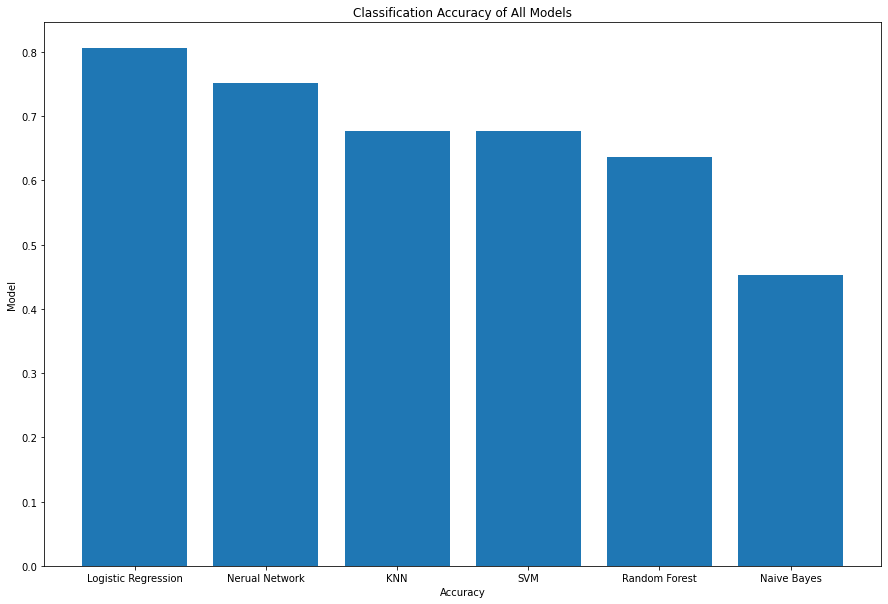

In [79]:

data = {'Logistic Regression': [0.80597],
        'Random Forest': [0.63681],
        'Nerual Network': [0.751243],
        'KNN': [0.67661691],
        'SVM': [ 0.67661691],
        'Naive Bayes': [0.4527363]}
df = pd.DataFrame(data).T
df_sorted = df.sort_values(by=0, ascending=False)

# Print the DataFrame
print(df_sorted)
plt.figure(figsize=(15, 10))
plt.bar(df_sorted.index, df_sorted[0])
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Classification Accuracy of All Models')
plt.show()

# The Relationship between lineage and gene.

In [80]:
np.unique(y1)

array(['bile_duct', 'blood', 'bone', 'breast', 'central_nervous_system',
       'cervix', 'colorectal', 'embryo', 'epidermoid_carcinoma',
       'esophagus', 'eye', 'gastric', 'kidney', 'liver', 'lung',
       'lymphocyte', 'ovary', 'pancreas', 'peripheral_nervous_system',
       'plasma_cell', 'prostate', 'skin', 'soft_tissue', 'thyroid',
       'unknown', 'upper_aerodigestive', 'urinary_tract', 'uterus'],
      dtype=object)

In [97]:
mean_ceres

NameError: name 'mean_ceres' is not defined

In [83]:
lineage = 'bile_duct'# replace with the name of the lineage of interest
lineage_idx = np.where(y1 == lineage)[0] # find the indices of samples belonging to the lineage

lineage_exp = exp2_s.iloc[:,lineage_idx] # extract the gene expression data for the lineage
lineage_ko = ac2_s.iloc[:, lineage_idx] # extract the knockout data for the lineage


In [84]:
lineage_exp

,ACH-001856,ACH-001673,ACH-000141,ACH-001853,ACH-000976,ACH-001494,ACH-001844,ACH-001960,ACH-001834,ACH-001862,...,ACH-001959,ACH-001857,ACH-001861,ACH-000209,ACH-001850,ACH-001997,ACH-001961,ACH-001864,ACH-001619,ACH-001841
1,0.0,0.545968,0.15056,0.163499,0.070389,0.042644,0.0,1.516015,0.070389,0.0,...,5.391974,0.124328,1.344828,1.014355,0.0,0.0,0.042644,4.760221,5.862451,0.0
2,0.0,0.163499,0.189034,0.0,0.111031,0.070389,0.042644,1.722466,0.201634,0.0,...,0.028569,0.111031,3.142413,0.263034,0.0,0.0,0.084064,0.263034,0.0,0.411426
131076,5.503985,7.284662,6.181699,5.143638,6.522935,5.226894,5.951634,5.845239,5.378858,5.425594,...,6.590512,6.590512,5.403949,4.719183,6.143026,5.587665,5.981853,6.709566,6.021035,6.787772
9,1.782409,3.311794,2.916477,2.797013,4.907371,3.403268,3.646163,2.819668,3.246408,2.759156,...,1.389567,0.790772,4.611172,1.182692,1.996389,3.68818,3.147307,3.798051,2.053111,2.682573
10,0.0,0.042644,0.070389,0.0,0.356144,0.565597,0.613532,0.0,0.704872,0.201634,...,0.042644,0.028569,1.137504,0.31034,0.0,0.454176,1.275007,1.799087,0.014355,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,0.238787,0.62293,2.229588,0.963474,0.887525,1.469886,1.432959,1.448901,1.432959,1.257011,...,1.799087,0.250962,2.070389,2.176323,0.584963,2.100978,0.773996,0.226509,1.077243,0.475085
327657,0.0,0.0,0.0,0.0,0.042644,0.0,0.0,0.0,0.0,0.070389,...,0.0,0.0,0.056584,0.0,0.056584,0.014355,0.0,0.0,0.0,0.0
201895,3.454176,5.210233,4.008092,3.899176,3.346248,5.934752,4.450221,5.995032,6.367022,5.41007,...,3.743084,5.408712,5.494416,3.134221,2.788686,6.278171,4.058316,5.614415,4.269033,5.1127
26048,1.594549,1.967169,2.087463,2.811471,0.485427,1.280956,2.275007,1.765535,2.046142,2.232661,...,1.726831,1.422233,2.160275,2.786596,2.003602,2.185867,1.395063,3.032101,1.541019,1.316146


In [86]:
lineage_ko

,ACH-001856,ACH-001673,ACH-000141,ACH-001853,ACH-000976,ACH-001494,ACH-001844,ACH-001960,ACH-001834,ACH-001862,...,ACH-001959,ACH-001857,ACH-001861,ACH-000209,ACH-001850,ACH-001997,ACH-001961,ACH-001864,ACH-001619,ACH-001841
1,-0.171777,-0.034547,0.006128,-0.000219,-0.127501,-0.026182,-0.008877,-0.072421,0.098811,0.1614,...,-0.050921,0.048896,0.01965,-0.140414,0.021977,0.062682,0.031196,-0.004311,-0.078895,0.030831
2,0.004972,0.029466,-0.076935,-0.087179,-0.088661,-0.022687,0.125891,0.0628,-0.002711,-0.056561,...,-0.083428,-0.074311,0.038525,-0.084079,0.054036,-0.077225,0.132117,-0.019658,0.268028,0.031832
131076,-0.191626,-0.510685,-0.355776,-0.53767,-0.438705,-0.273662,-0.336706,-0.502934,-0.224634,-0.24654,...,-0.108799,-0.6434,-0.029549,-0.865616,-0.236995,-0.41927,-0.285698,-0.180572,-0.485618,-0.230911
9,0.115673,0.100869,0.200313,0.124092,0.250092,-0.012281,0.090208,0.087899,0.231397,0.25635,...,0.18164,0.070745,0.084139,0.088251,0.097561,0.118618,0.003616,0.134431,0.244749,0.102987
10,-0.013025,0.103846,0.102943,0.11725,0.064335,0.032675,0.140889,0.061154,0.010546,0.025947,...,-0.043941,-0.009952,0.070298,0.125346,0.085867,-0.106254,0.05903,0.112965,0.183403,0.077205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,-0.002673,-0.085324,0.101127,0.110126,0.009925,0.011395,0.015358,-0.032299,0.016953,-0.166743,...,0.037435,-0.078342,0.176262,-0.139578,0.059659,0.183875,-0.067391,-0.084253,-0.068186,0.015092
327657,0.092486,0.029249,-0.068999,0.151519,-0.058423,0.031124,0.032618,0.106844,0.144669,0.066363,...,0.003535,0.018182,0.091908,-0.021936,0.164342,0.056724,0.110987,0.186825,0.255079,0.038084
201895,0.081304,0.111989,0.210445,0.118476,0.170616,0.100135,0.210689,0.112486,0.044424,0.114751,...,0.216595,0.218732,0.05241,0.140622,0.102388,0.173885,0.063236,0.198695,0.044043,0.114028
26048,-0.026761,-0.067948,0.019559,-0.09848,-0.122133,-0.302959,0.020797,0.008641,-0.087483,0.039051,...,0.005263,-0.191434,-0.029042,-0.18351,-0.142203,-0.03429,-0.159753,-0.031164,-0.160695,-0.0722


In [85]:
y1['ACH-001856']

'bile_duct'

In [95]:
gke = np.log2(lineage_exp.mean(axis=1) / (lineage_exp * lineage_ko).mean(axis=1))


In [96]:
gke

1              NaN
2         5.129183
131076         NaN
9         3.223923
10        4.076352
            ...   
6508      5.126738
327657    3.677986
201895    3.177310
26048          NaN
26050     7.106078
Length: 17440, dtype: float64

In [90]:
lineage_exp.mean(axis=0) / (lineage_exp * lineage_ko).mean(axis=0)

ACH-001856   -3.023997
ACH-001673   -3.185746
ACH-000141   -3.454987
ACH-001853   -3.303946
ACH-000976   -3.076158
ACH-001494   -3.256596
ACH-001844   -3.276826
ACH-001960   -3.336455
ACH-001834   -3.429907
ACH-001862   -3.171999
ACH-001836   -3.453091
ACH-001536   -3.094403
ACH-001607   -3.085480
ACH-001843   -3.225489
ACH-001839   -3.295171
ACH-001848   -3.269875
ACH-001538   -3.217520
ACH-001852   -3.183340
ACH-001863   -3.217772
ACH-000461   -3.065248
ACH-001858   -3.240610
ACH-001849   -2.945652
ACH-000377   -3.183488
ACH-001838   -3.332372
ACH-001842   -3.449382
ACH-000182   -3.459897
ACH-001835   -3.265109
ACH-001959   -2.914288
ACH-001857   -3.128692
ACH-001861   -3.311153
ACH-000209   -3.391438
ACH-001850   -3.025621
ACH-001997   -3.218574
ACH-001961   -3.294288
ACH-001864   -3.397498
ACH-001619   -3.095567
ACH-001841   -3.137454
dtype: float64

In [107]:
len(mean_ceres[lineage_idx])

37

In [119]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Load gene expression data and labels
lineage = 'bile_duct'# replace with the name of the lineage of interest
lineage_idx = np.where(y1 == lineage)[0] # find the indices of samples belonging to the lineage

lineage_exp = exp2_s.iloc[:,lineage_idx] # extract the gene expression data for the lineage
lineage_ko = ac2_s.iloc[:, lineage_idx] # extract the knockout data for the lineage
lineage_labels = mean_ceres[lineage_idx]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lineage_exp, lineage_labels, test_size=0.2, random_state=42)



# Alternatively, perform feature selection using RFECV and random forest classification
# selector = RFECV(RandomForestClassifier(n_estimators=100), cv=5, scoring='accuracy')
# selector.fit(X_train, y_train)
# selected_genes = X_train.columns[selector.support_]

# Train a random forest classifier on the selected genes
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict the lineage of the test set and evaluate the model's performance
y_pred = clf.predict(X_test[selected_genes])
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2 score: {r2}")
print(f"Mean squared error: {mse}")



C:\Users\10096\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)


R2 score: 0.5800866214423821
Mean squared error: 0.00027141223289608486
Selected genes:
Index([387893,  27445,  57558, 158521,  57559,  92999, 285513, 387914, 387921,
        93010,
       ...
       196541, 163778, 163782, 163786, 131034,   6508, 327657, 201895,  26048,
        26050],
      dtype='object', length=1700)


In [127]:
Allin=pd.DataFrame()

for lineage in np.unique(y1):
 # replace with the name of the lineage of interest
    lineage_idx = np.where(y1 == lineage)[0] # find the indices of samples belonging to the lineage

#lineage_exp = exp2_s.iloc[:, lineage_idx].T # extract the gene expression data for the lineage
#lineage_ko = ac2_s.iloc[:, lineage_idx] # extract the knockout data for the lineage
    lineage_labels = ceres[lineage_idx]
    vac = np.mean(lineage_labels, axis=0)
    Allin[lineage]=vac





In [125]:
max(importances)

0.03488609069898181

In [128]:
Allin

,bile_duct,blood,bone,breast,central_nervous_system,cervix,colorectal,embryo,epidermoid_carcinoma,esophagus,...,peripheral_nervous_system,plasma_cell,prostate,skin,soft_tissue,thyroid,unknown,upper_aerodigestive,urinary_tract,uterus
0,0.141476,0.872784,0.750501,0.718504,0.669674,0.294804,0.159145,0.791724,0.0,0.350513,...,0.844581,0.583199,0.45581,0.83209,0.764425,0.800076,0.826562,0.29492,0.302548,0.662791
1,0.116191,0.119529,0.38414,0.144118,0.371463,0.124951,0.06074,0.214635,0.0,0.147228,...,0.137076,0.036681,0.136602,0.761047,0.176618,0.049735,0.955585,0.067233,0.074228,0.038186
2,1.187423,1.137187,1.182921,1.107515,1.166257,1.173399,1.214394,1.189807,1.382647,1.188942,...,1.160821,1.158812,1.1551,1.177395,1.151934,1.177054,1.084049,1.125802,1.153549,1.168449
3,0.603344,0.641053,0.529925,0.532386,0.482215,0.426317,0.608663,0.546726,0.41285,0.534574,...,0.352369,0.549118,0.579599,0.560637,0.439935,0.449609,0.613744,0.486055,0.52815,0.521512
4,0.077233,0.001667,0.019657,0.069726,0.038145,0.018789,0.187959,0.261316,0.012506,0.064024,...,0.057712,0.00116,0.029351,0.02024,0.039048,0.051999,0.01523,0.016061,0.02318,0.045313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17435,0.346212,0.042111,0.385183,0.468191,0.556207,0.277341,0.386685,0.438839,0.50082,0.436964,...,0.410739,0.008407,0.514643,0.57852,0.423118,0.430469,0.506977,0.45032,0.487682,0.456859
17436,0.003368,0.003141,0.01975,0.007139,0.038086,0.003259,0.016341,0.0,0.0,0.008394,...,0.003715,0.000697,0.002679,0.007725,0.025157,0.040907,0.0,0.010937,0.013168,0.018711
17437,0.921386,0.53091,0.747971,0.866093,0.806319,0.741922,0.772469,0.761947,0.754456,0.718542,...,0.732293,0.561883,0.848494,0.660066,0.686471,0.767147,0.678978,0.678285,0.740758,0.691331
17438,0.476528,0.578537,0.574558,0.581675,0.586195,0.422524,0.528524,0.2604,0.412269,0.533892,...,0.589836,0.589075,0.494367,0.541335,0.532002,0.539721,0.521835,0.452743,0.524406,0.559269


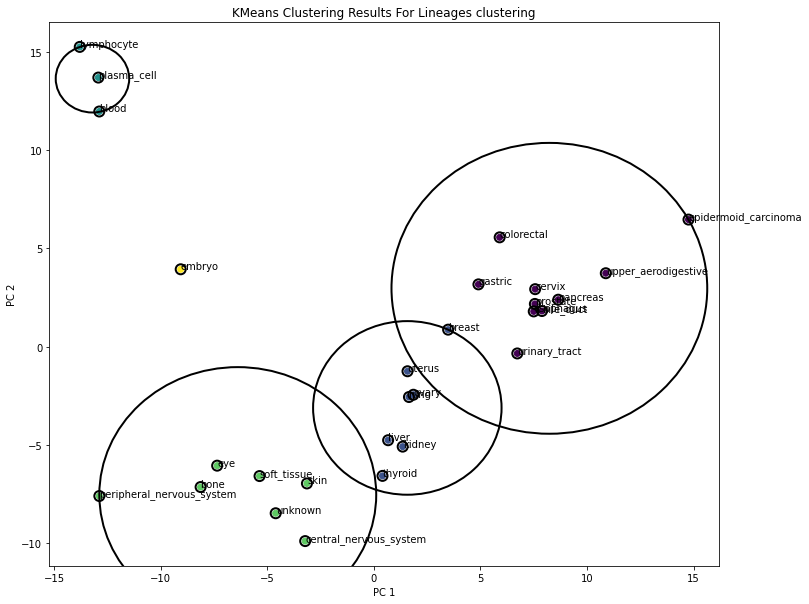

In [169]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
# Apply K-means clustering
n_clu=5
#kmeans = KMeans(n_clusters=n_clu, random_state=0)
pca = PCA(n_components=2)
Allin_reduced = pca.fit_transform(Allin.T)


kmeans_Allin =  KMeans(n_clusters=n_clu, random_state=0).fit(Allin_reduced)

fig, ax = plt.subplots(figsize=(12, 10))

plt.scatter(Allin_reduced[:, 0], Allin_reduced[:, 1], c=kmeans_Allin.labels_)
for i, txt in enumerate(Allin.columns):
    ax.annotate(txt, (Allin_reduced[i, 0], Allin_reduced[i, 1]))
plt.title("KMeans Clustering Results For Lineages clustering")
for i in range(5):
    idx = np.where(kmeans_Allin.labels_ == i)[0]
    x_mean = np.mean(Allin_reduced[idx, 0])
    y_mean = np.mean(Allin_reduced[idx, 1])
    radius = np.max(np.sqrt((Allin_reduced[idx, 0]-x_mean)**2 + (Allin_reduced[idx, 1]-y_mean)**2))
    plt.scatter(Allin_reduced[idx, 0], Allin_reduced[idx, 1], edgecolors='black', linewidths=2, facecolors='none', s=100)
    plt.gca().add_artist(plt.Circle((x_mean, y_mean), radius, color='black', fill=False, linewidth=2))

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

In [130]:
Allin_reduced.shape

(17440, 2)

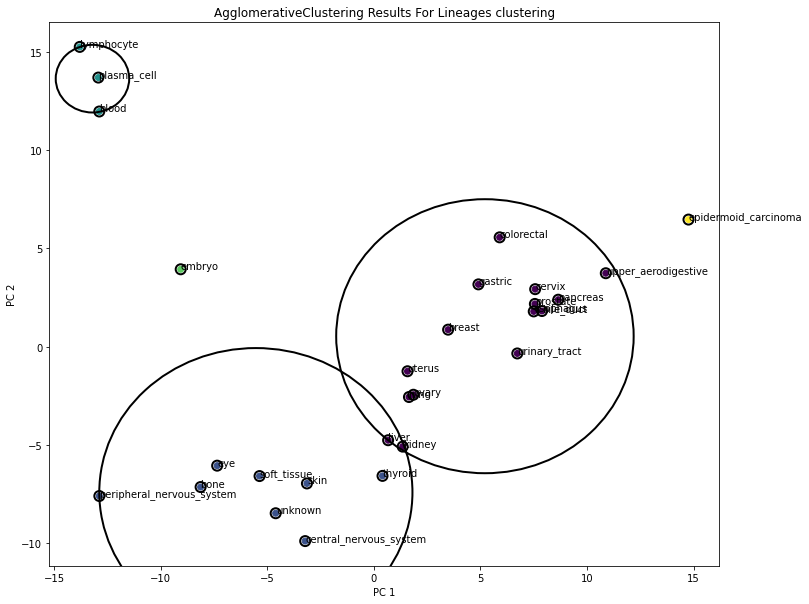

Adjusted Rand Index for KMeans: 0.5286473715298287
Silhouette Score for KMeans: 0.5419291261950712
Silhouette Score for Hierarchical Clustering: 0.41239368899852985


In [168]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply hierarchical clustering
n_clu = 5
agg_cluster = AgglomerativeClustering(n_clusters=n_clu)
agg_cluster.fit(Allin.T)

# Visualize the results
pca = PCA(n_components=2)
Allin_reduced = pca.fit_transform(Allin.T)

kmeans_Allin =  KMeans(n_clusters=n_clu, random_state=0).fit(Allin_reduced)


fig, ax = plt.subplots(figsize=(12, 10))

plt.scatter(Allin_reduced[:, 0], Allin_reduced[:, 1], c=agg_cluster.labels_)
for i, txt in enumerate(Allin.columns):
    ax.annotate(txt, (Allin_reduced[i, 0], Allin_reduced[i, 1]))
plt.title("AgglomerativeClustering Results For Lineages clustering")
for i in range(5):
    idx = np.where(agg_cluster.labels_ == i)[0]
    x_mean = np.mean(Allin_reduced[idx, 0])
    y_mean = np.mean(Allin_reduced[idx, 1])
    radius = np.max(np.sqrt((Allin_reduced[idx, 0]-x_mean)**2 + (Allin_reduced[idx, 1]-y_mean)**2))
    plt.scatter(Allin_reduced[idx, 0], Allin_reduced[idx, 1], edgecolors='black', linewidths=2, facecolors='none', s=100)
    plt.gca().add_artist(plt.Circle((x_mean, y_mean), radius, color='black', fill=False, linewidth=2))

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

# Compare the classification scheme of KMeans and hierarchical clustering
print("Adjusted Rand Index for KMeans:", adjusted_rand_score(kmeans_Allin.labels_, agg_cluster.labels_))
print("Silhouette Score for KMeans:", silhouette_score(Allin_reduced, kmeans_Allin.labels_))
print("Silhouette Score for Hierarchical Clustering:", silhouette_score(Allin_reduced, agg_cluster.labels_))


In [166]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, SpectralClustering, Birch

# Apply hierarchical clustering
n_clu = 20
agg_cluster = AgglomerativeClustering(n_clusters=n_clu)
agg_cluster.fit(exp2_np)

# Visualize the results
pca = PCA(n_components=2)
Allin_reduced = pca.fit_transform(exp2_np)
kmeans_Allin =  KMeans(n_clusters=n_clu, random_state=0).fit(exp2_np)


#dbscan = DBSCAN(eps=5, min_samples=5)
#dbscan_labels = dbscan.fit_predict(exp2_np)

#spectral = SpectralClustering(n_clusters=n_clu)
#spectral_labels = spectral.fit_predict(exp2_np)
#birch = Birch(threshold=0.5, n_clusters=n_clu)
#birch_labels = birch.fit_predict(exp2_np)

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Clustering of combined Dataset using KMean")
plt.scatter(Allin_reduced[:, 0], Allin_reduced[:, 1], c=agg_cluster.labels_)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

plt.show()

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("Clustering of Combined Dataset using PCA")
plt.scatter(Allin_reduced[:, 0], Allin_reduced[:, 1], c=kmeans_Allin.labels_)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()


plt.show()



# Compare the classification scheme of KMeans and hierarchical clustering
print("Adjusted Rand Index for KMeans:", adjusted_rand_score(kmeans_Allin.labels_, agg_cluster.labels_))
#print("Adjusted Rand Index for KMeans vs Ga:", adjusted_rand_score(kmeans_Allin.labels_, birch_labels))
#print("Adjusted Rand Index for KMeans vs Ga:", adjusted_rand_score(kmeans_Allin.labels_, spectral_labels))
print("Silhouette Score for KMeans:", silhouette_score(Allin_reduced, kmeans_Allin.labels_))
print("Silhouette Score for Hierarchical Clustering:", silhouette_score(Allin_reduced, agg_cluster.labels_))


NameError: name 'C' is not defined